Downloading...
From: https://drive.google.com/uc?export=download&id=1mGvSprHEiezeIH3jxlxk_u8YTTsHzp2y
To: /Users/niy4/diabetes_dataset.csv
100%|██████████████████████████████████████| 3.81M/3.81M [00:00<00:00, 4.95MB/s]


Missing values:
 gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

Sample sizes:
Training set: 67302 records (70.00%)
Validation set: 14422 records (15.00%)
Test set: 14422 records (15.00%)

Class proportions:
Training set:
 diabetes
0   0.91
1   0.09
Name: proportion, dtype: float64
Validation set:
 diabetes
0   0.91
1   0.09
Name: proportion, dtype: float64
Test set:
 diabetes
0   0.91
1   0.09
Name: proportion, dtype: float64

### Random Forest Results ###
Best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97     13150
           1       0.68      0.82      0.74      1272

    accuracy                           0.95

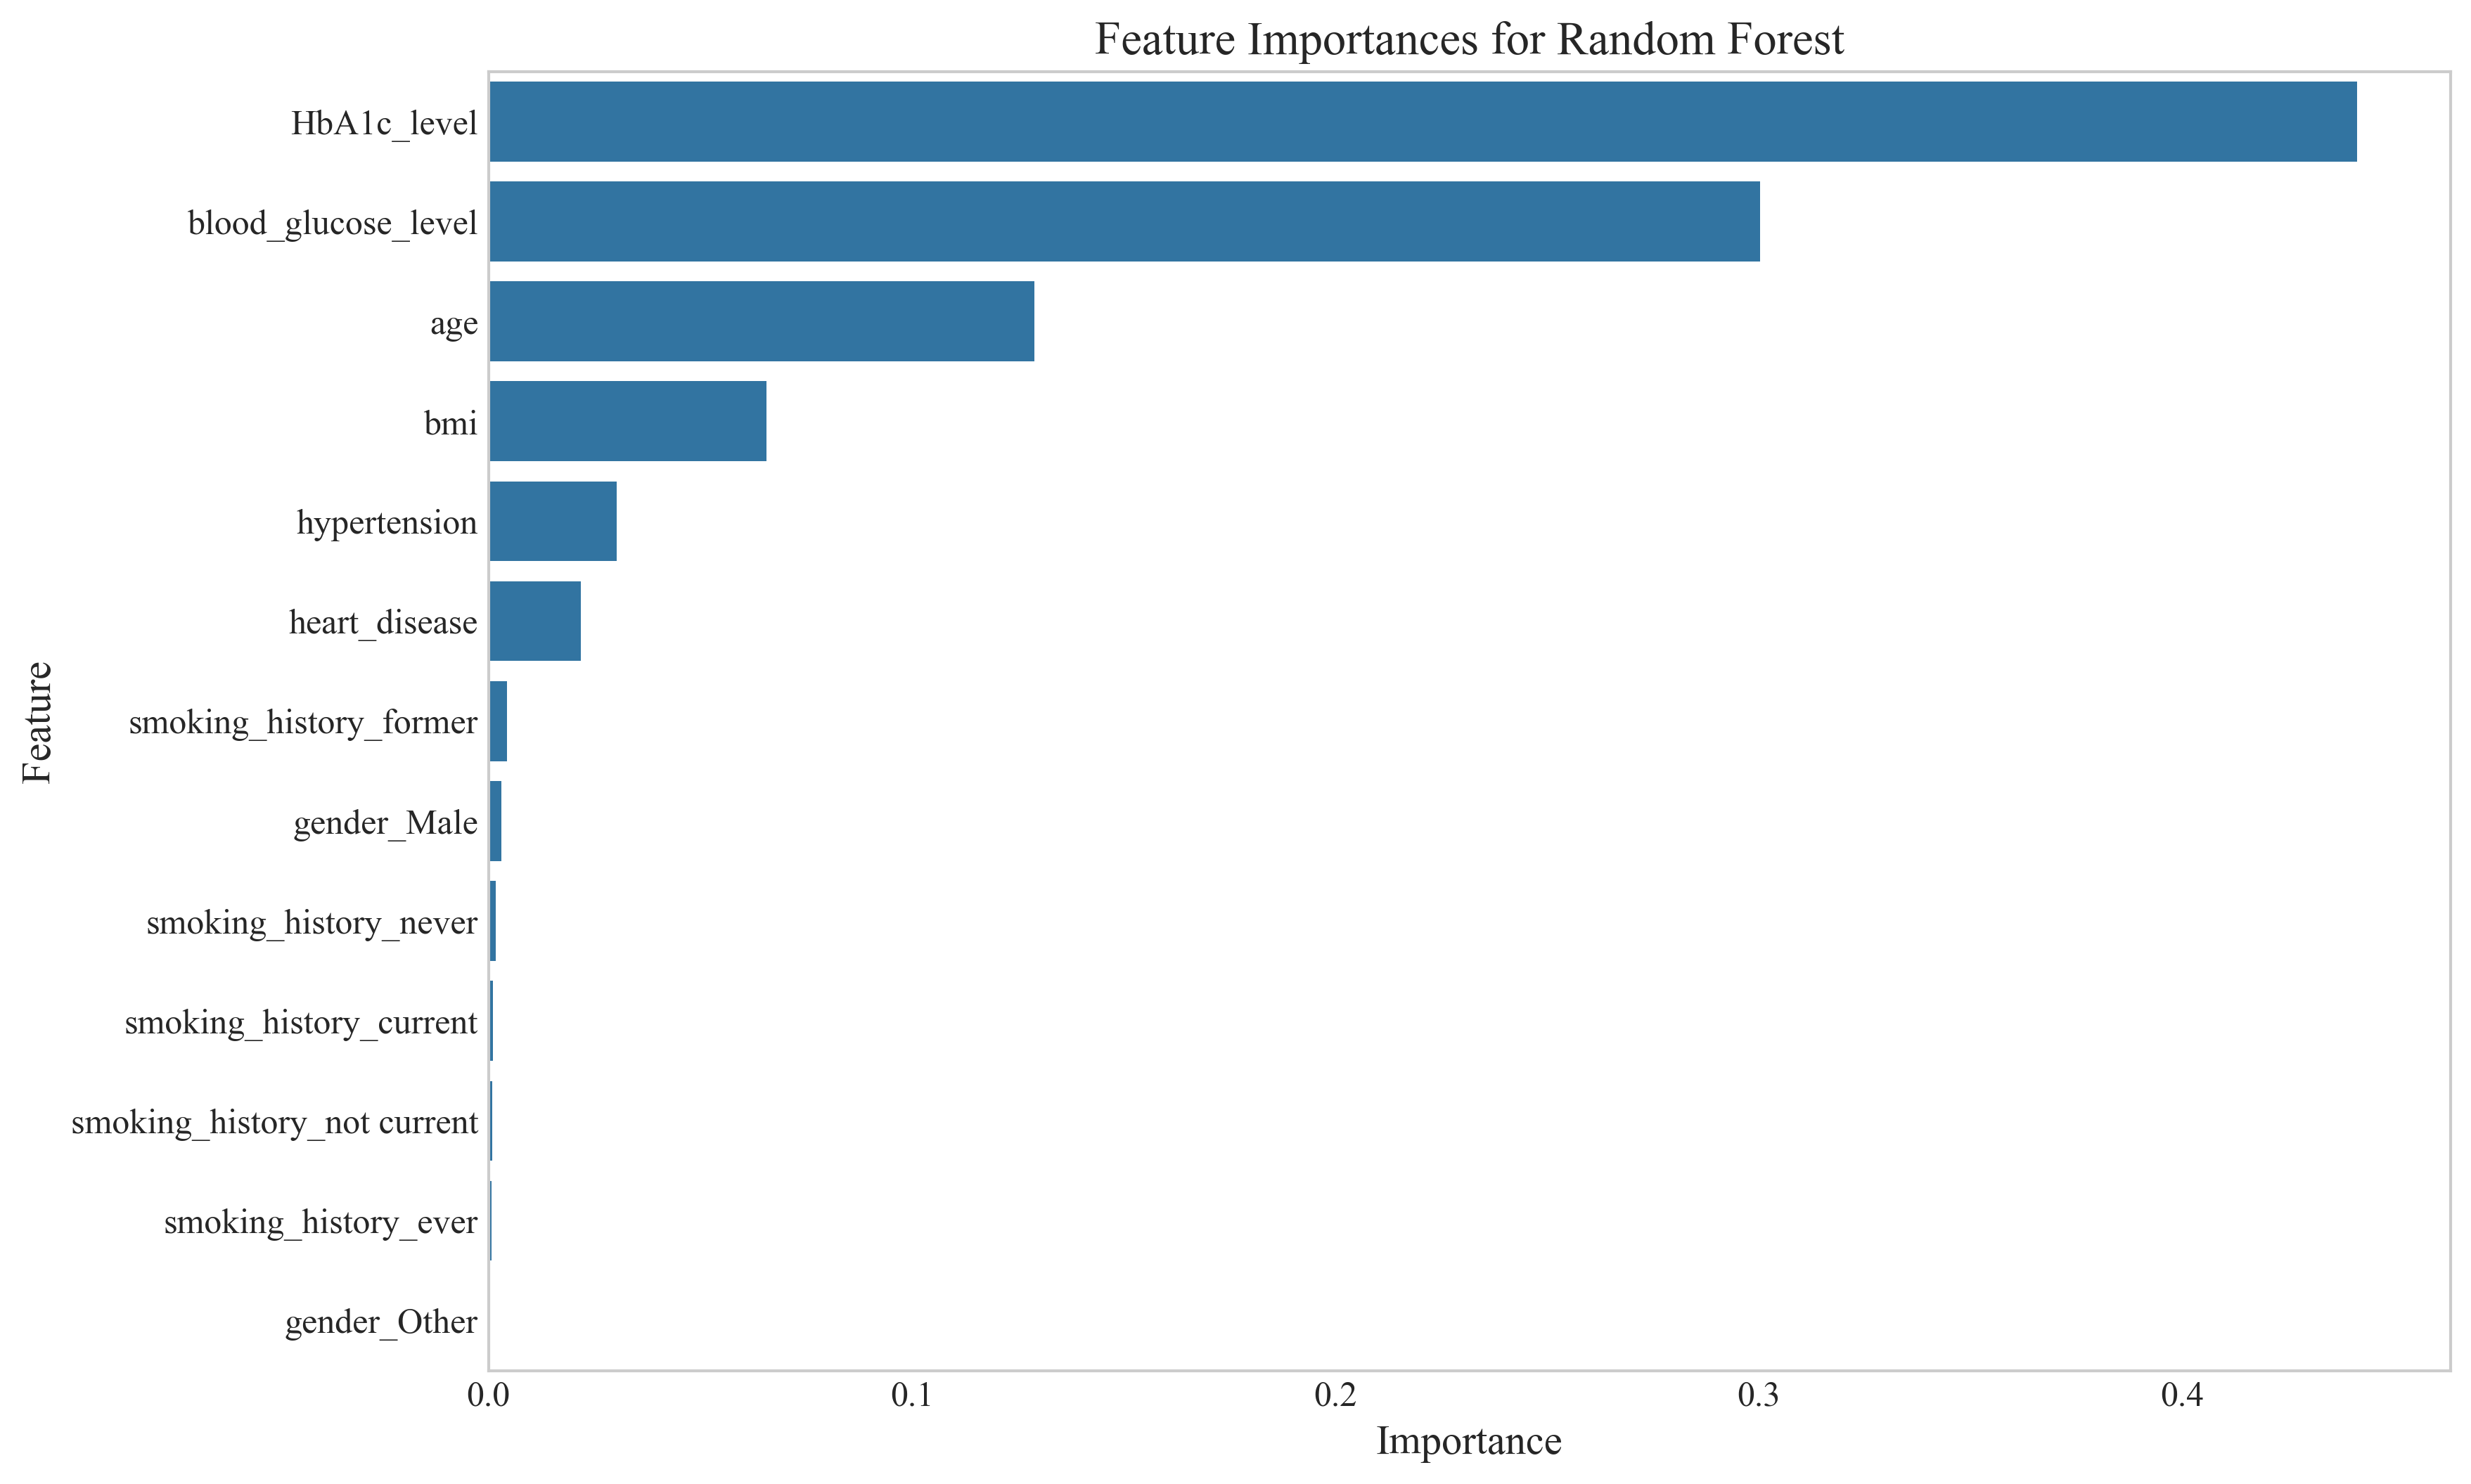


### Logistic Regression Results ###
Best parameters: {'classifier__C': 1, 'classifier__penalty': 'l2'}
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96     13150
           1       0.56      0.82      0.67      1272

    accuracy                           0.93     14422
   macro avg       0.77      0.88      0.81     14422
weighted avg       0.94      0.93      0.93     14422

Confusion Matrix:
 [[12324   826]
 [  225  1047]]
ROC-AUC Score: 0.9638839766123825

### SVM Results ###
Best parameters: {'classifier__C': 10, 'classifier__kernel': 'rbf'}
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.97     13150
           1       0.61      0.82      0.70      1272

    accuracy                           0.94     14422
   macro avg       0.80      0.89      0.83     14422
weighted avg       0.95      0.94      0.94     14422

Confusion Matrix:
 [[

In [40]:
import warnings
warnings.filterwarnings('ignore')

# Import libraries
import numpy as np
import pandas as pd
import gdown

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import models and metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Set display format for numbers
pd.options.display.float_format = "{:.2f}".format

# Download data from Google Drive
file_id = "1mGvSprHEiezeIH3jxlxk_u8YTTsHzp2y"
url = f"https://drive.google.com/uc?export=download&id={file_id}"
output = "diabetes_dataset.csv"
gdown.download(url, output, quiet=False)
df = pd.read_csv('diabetes_dataset.csv')

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Remove duplicates
df = df.drop_duplicates()

# Define numerical and categorical features
numeric_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'hypertension', 'heart_disease']
categorical_features = ['gender', 'smoking_history']

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

# Split data into features and target variable
X = df.drop('diabetes', axis=1)
y = df['diabetes']

# Split the data into train, validation, and test sets: 70/15/15
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Check the size of each set
print("\nSample sizes:")
print(f"Training set: {X_train.shape[0]} records ({X_train.shape[0]/len(df):.2%})")
print(f"Validation set: {X_val.shape[0]} records ({X_val.shape[0]/len(df):.2%})")
print(f"Test set: {X_test.shape[0]} records ({X_test.shape[0]/len(df):.2%})")

# Check class proportions
print("\nClass proportions:")
print("Training set:\n", y_train.value_counts(normalize=True).round(3))
print("Validation set:\n", y_val.value_counts(normalize=True).round(3))
print("Test set:\n", y_test.value_counts(normalize=True).round(3))

# Define the models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(probability=True, random_state=42)
}

# Train and evaluate each model
for name, model in models.items():
    # Define pipeline with class balancing
    pipeline = imbPipeline([
        ('preprocessor', preprocessor),
        ('over', SMOTE(sampling_strategy=0.1, random_state=42)),
        ('under', RandomUnderSampler(sampling_strategy=0.5, random_state=42)),
        ('classifier', model)
    ])

    # Define hyperparameter grid
    if name == 'Random Forest':
        param_grid = {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [10, 20, None],
            'classifier__min_samples_split': [2, 5]
        }
    elif name == 'Logistic Regression':
        param_grid = {
            'classifier__C': [0.1, 1, 10],
            'classifier__penalty': ['l2']
        }
    elif name == 'SVM':
        param_grid = {
            'classifier__C': [0.1, 1, 10],
            'classifier__kernel': ['linear', 'rbf']
        }

    # Run GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_model = grid_search.best_estimator_

    # Predictions on the test set
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # Evaluation results
    print(f"\n### {name} Results ###")
    print("Best parameters:", grid_search.best_params_)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

    # Feature importance for Random Forest
    if name == 'Random Forest':
        # Get feature names
        feature_names = numeric_features + list(best_model.named_steps['preprocessor']
                                                .named_transformers_['cat']
                                                .get_feature_names_out(categorical_features))
        importances = best_model.named_steps['classifier'].feature_importances_

        # Create and sort DataFrame with feature importances
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        importance_df = importance_df.sort_values('Importance', ascending=False)

        # Visualization
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=importance_df)
        plt.title(f'Feature Importances for {name}')
        plt.show()


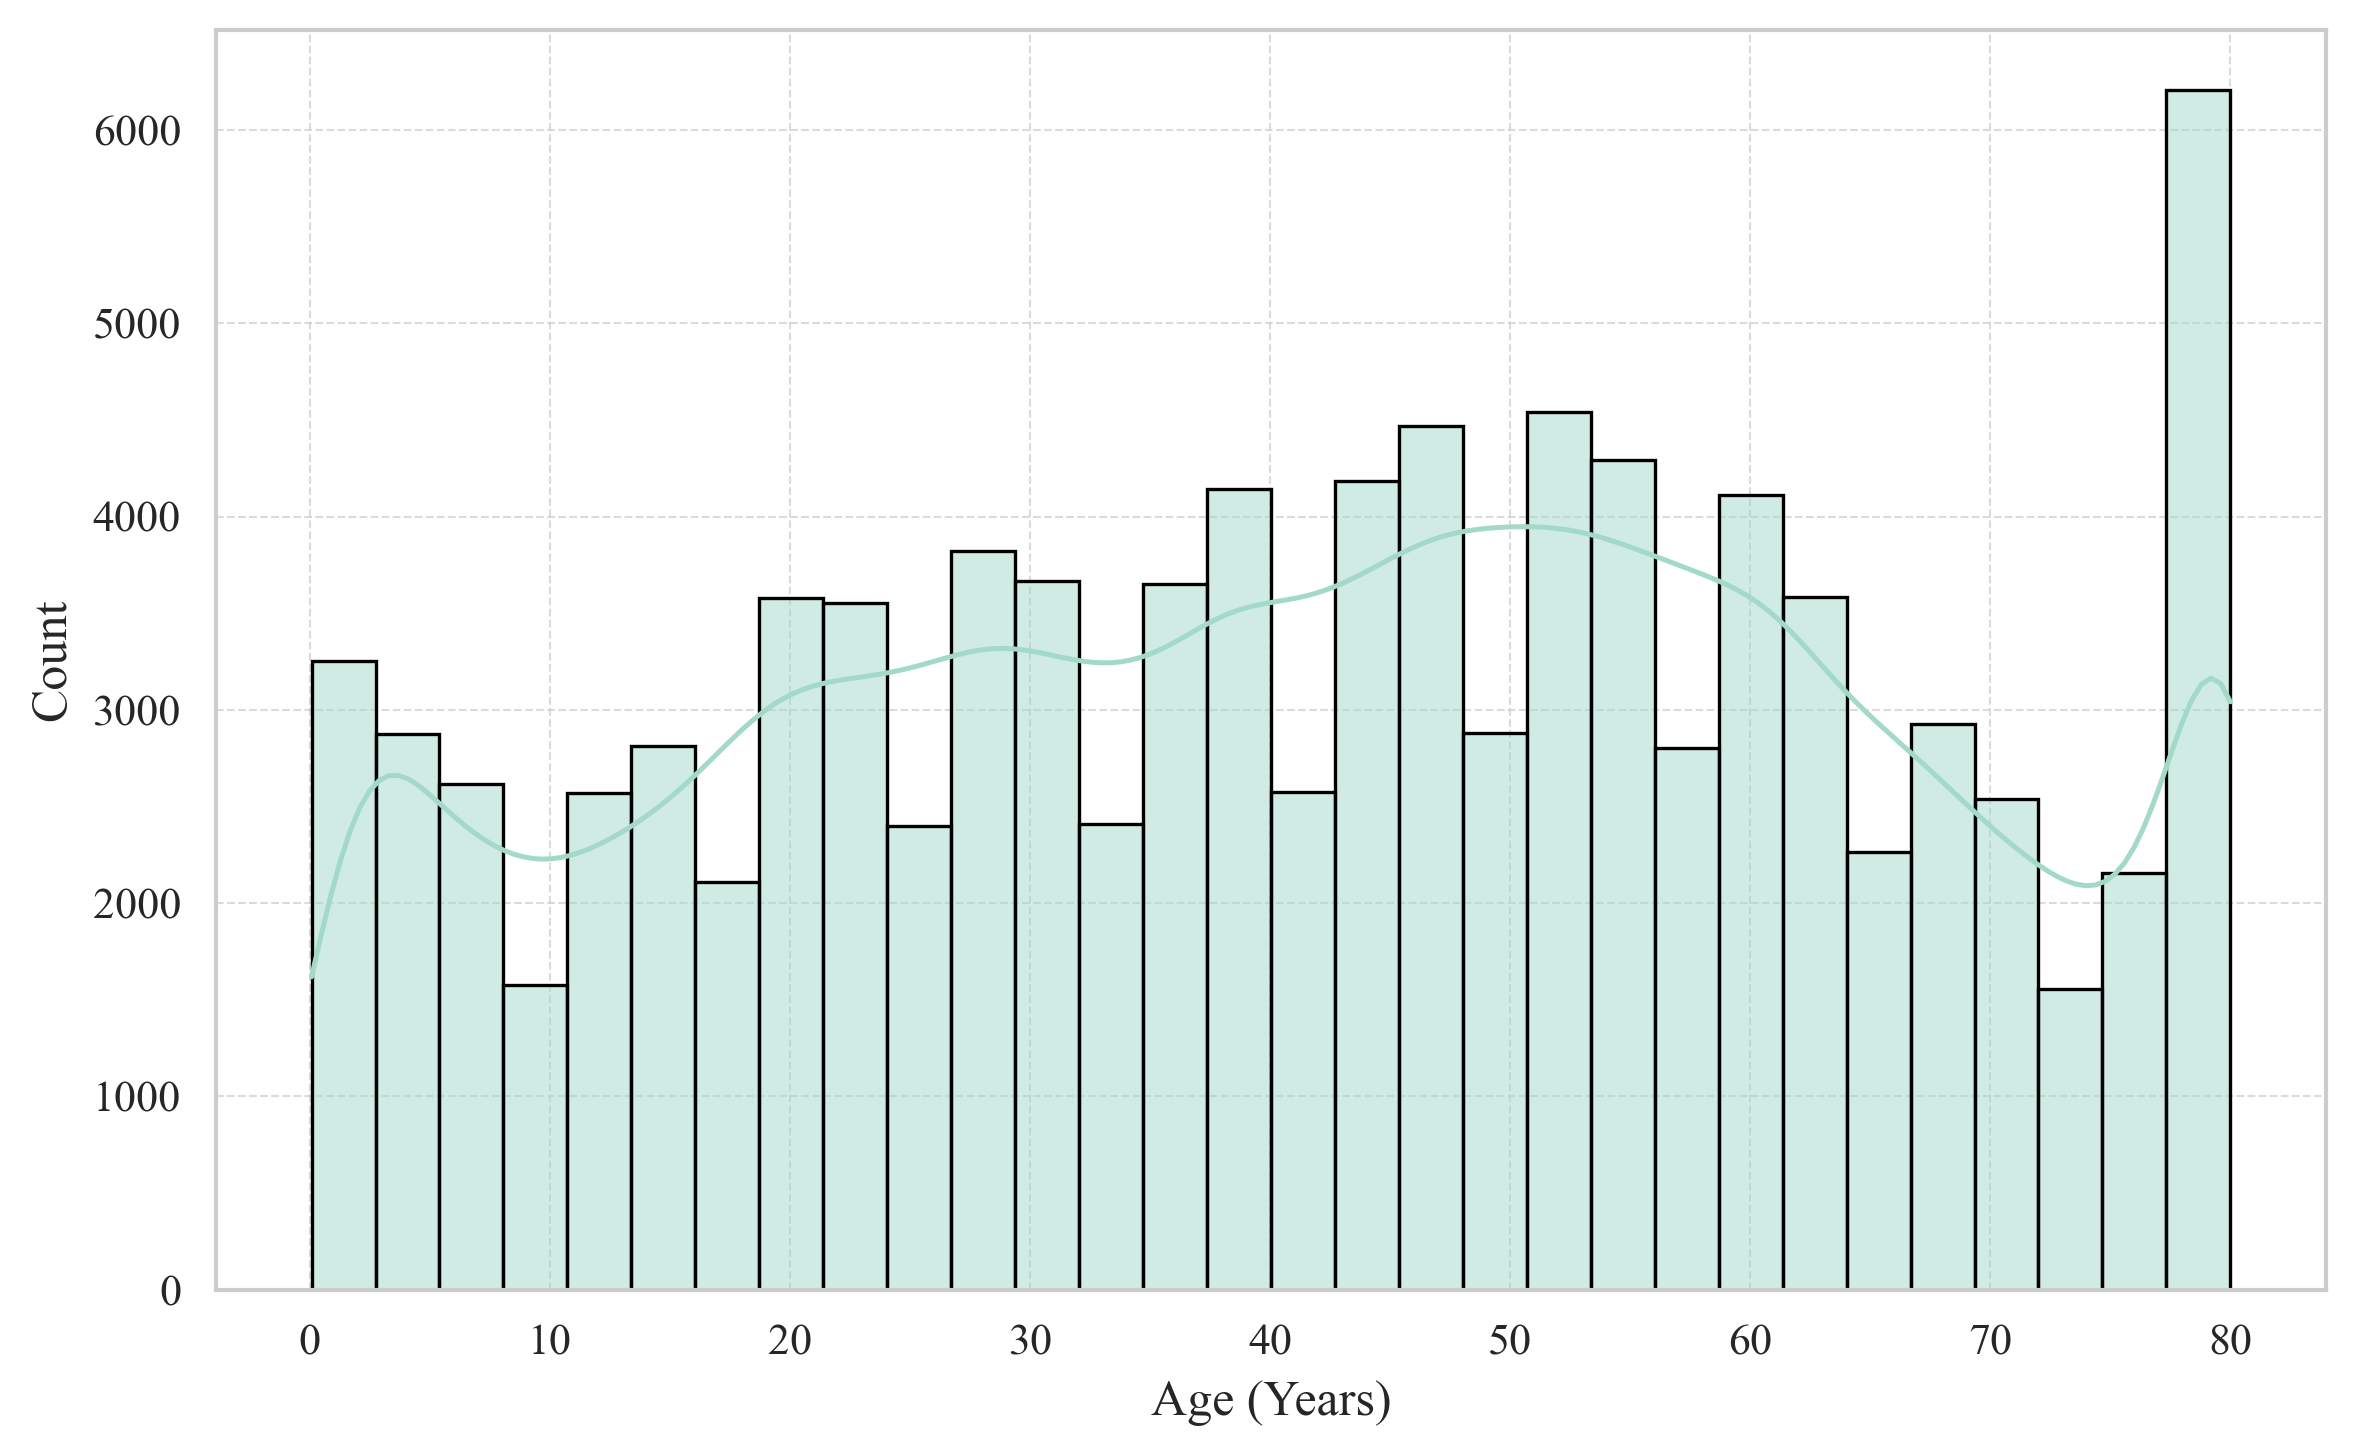

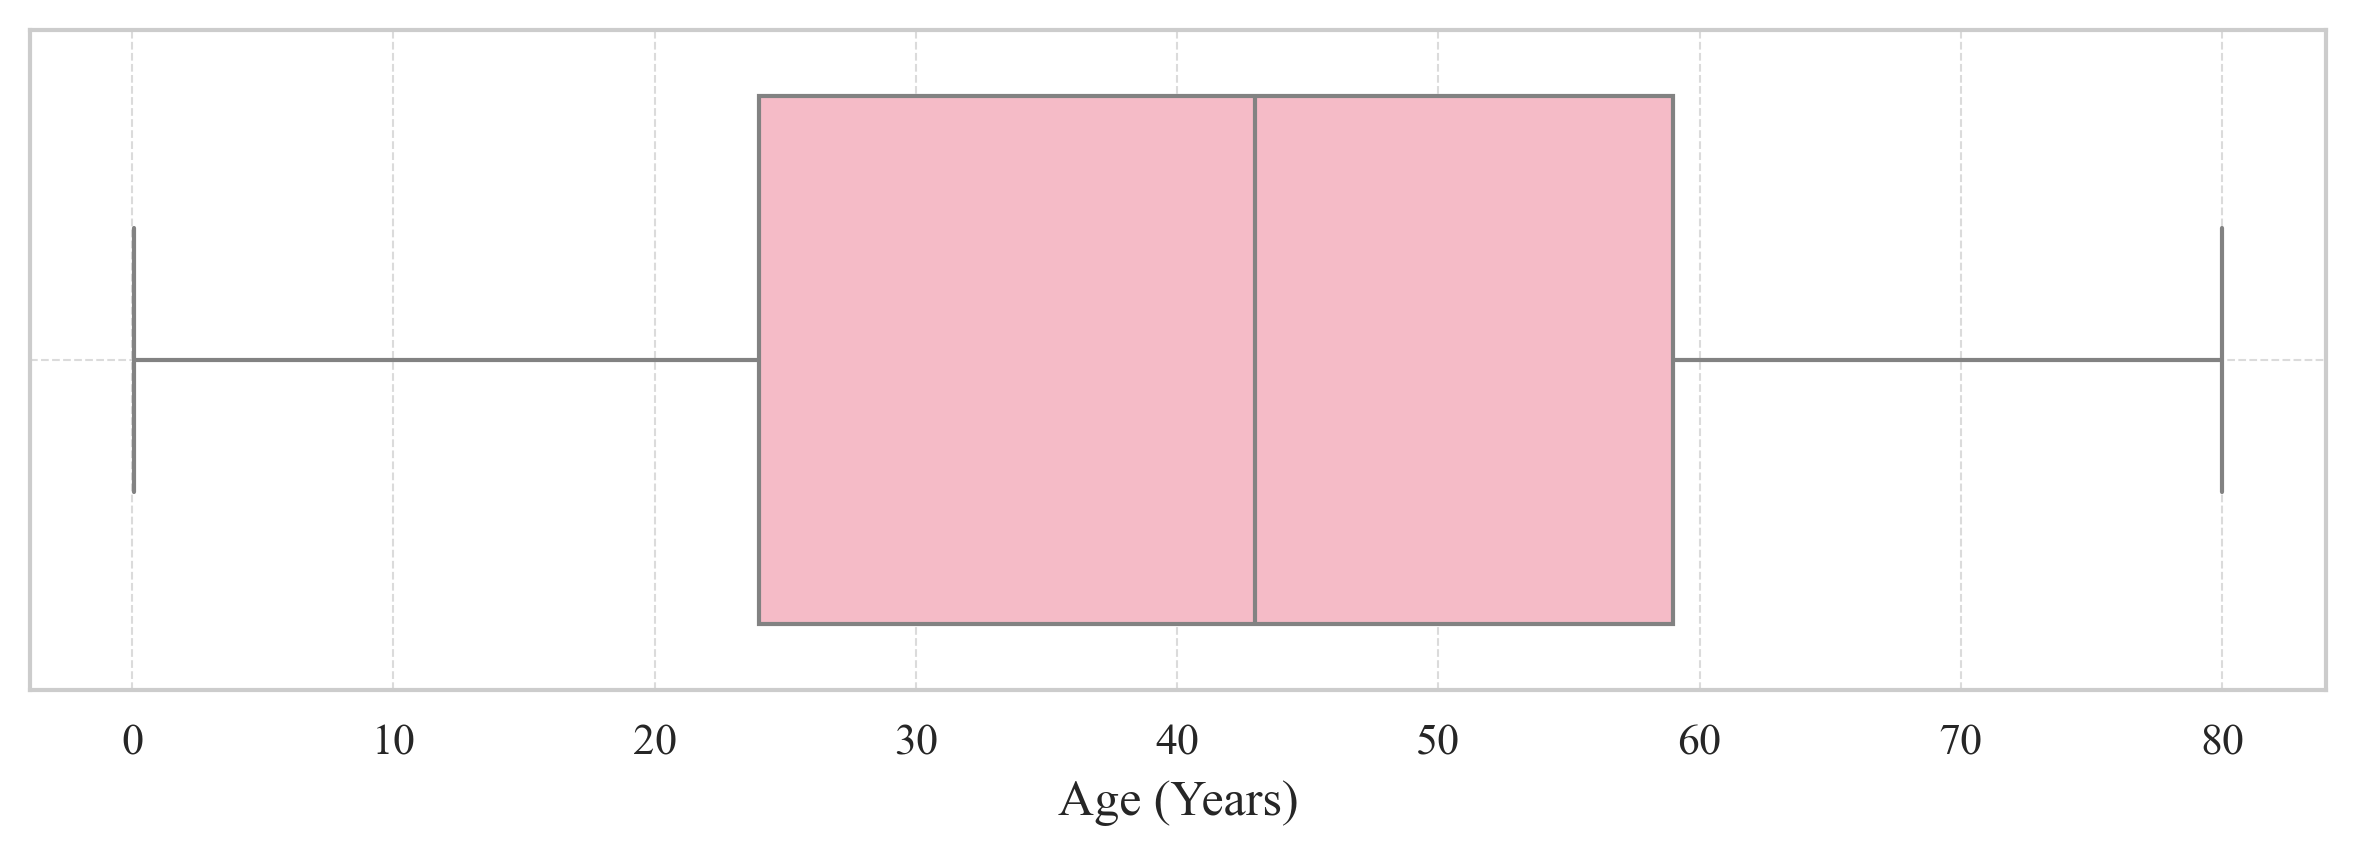

Число пациентов с возрастом 80 лет: 4932

Статистика возраста:
count   96146.00
mean       41.79
std        22.46
min         0.08
25%        24.00
50%        43.00
75%        59.00
max        80.00


In [44]:

# Установка шрифта Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12  # Базовый размер шрифта

# Установка стиля для научной статьи
sns.set_theme(style='whitegrid', context='paper', font='Times New Roman', font_scale=1.2)

# Холодные пастельные цвета
color_hist = '#a3d9c9'  # Мятный зелёный для гистограммы
color_box = '#ffb1c1'   # Холодный розовый для ящика с усами

# Предполагается, что df уже загружен (например, df = pd.read_csv('diabetes_dataset.csv'))
# Гистограмма по возрасту
plt.figure(figsize=(8, 5), dpi=300)  # Большой размер (8x5 дюймов) и высокое разрешение
sns.histplot(df['age'], bins=30, kde=True, color=color_hist, edgecolor='black')
plt.xlabel('Age (Years)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig('age_histogram.png', dpi=300, bbox_inches='tight', format='png')
plt.show()

# Ящик с усами по возрасту
plt.figure(figsize=(8, 3), dpi=300)  # Большой размер (8x3 дюймов) и высокое разрешение
sns.boxplot(x=df['age'], color=color_box)
plt.xlabel('Age (Years)', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig('age_boxplot.png', dpi=300, bbox_inches='tight', format='png')
plt.show()

# Анализ возраста
max_age_count = (df['age'] == 80).sum()
print(f'Число пациентов с возрастом 80 лет: {max_age_count}')

# Основные квантильные значения
age_stats = df['age'].describe()
print('\nСтатистика возраста:')
print(age_stats.round(2).to_string())

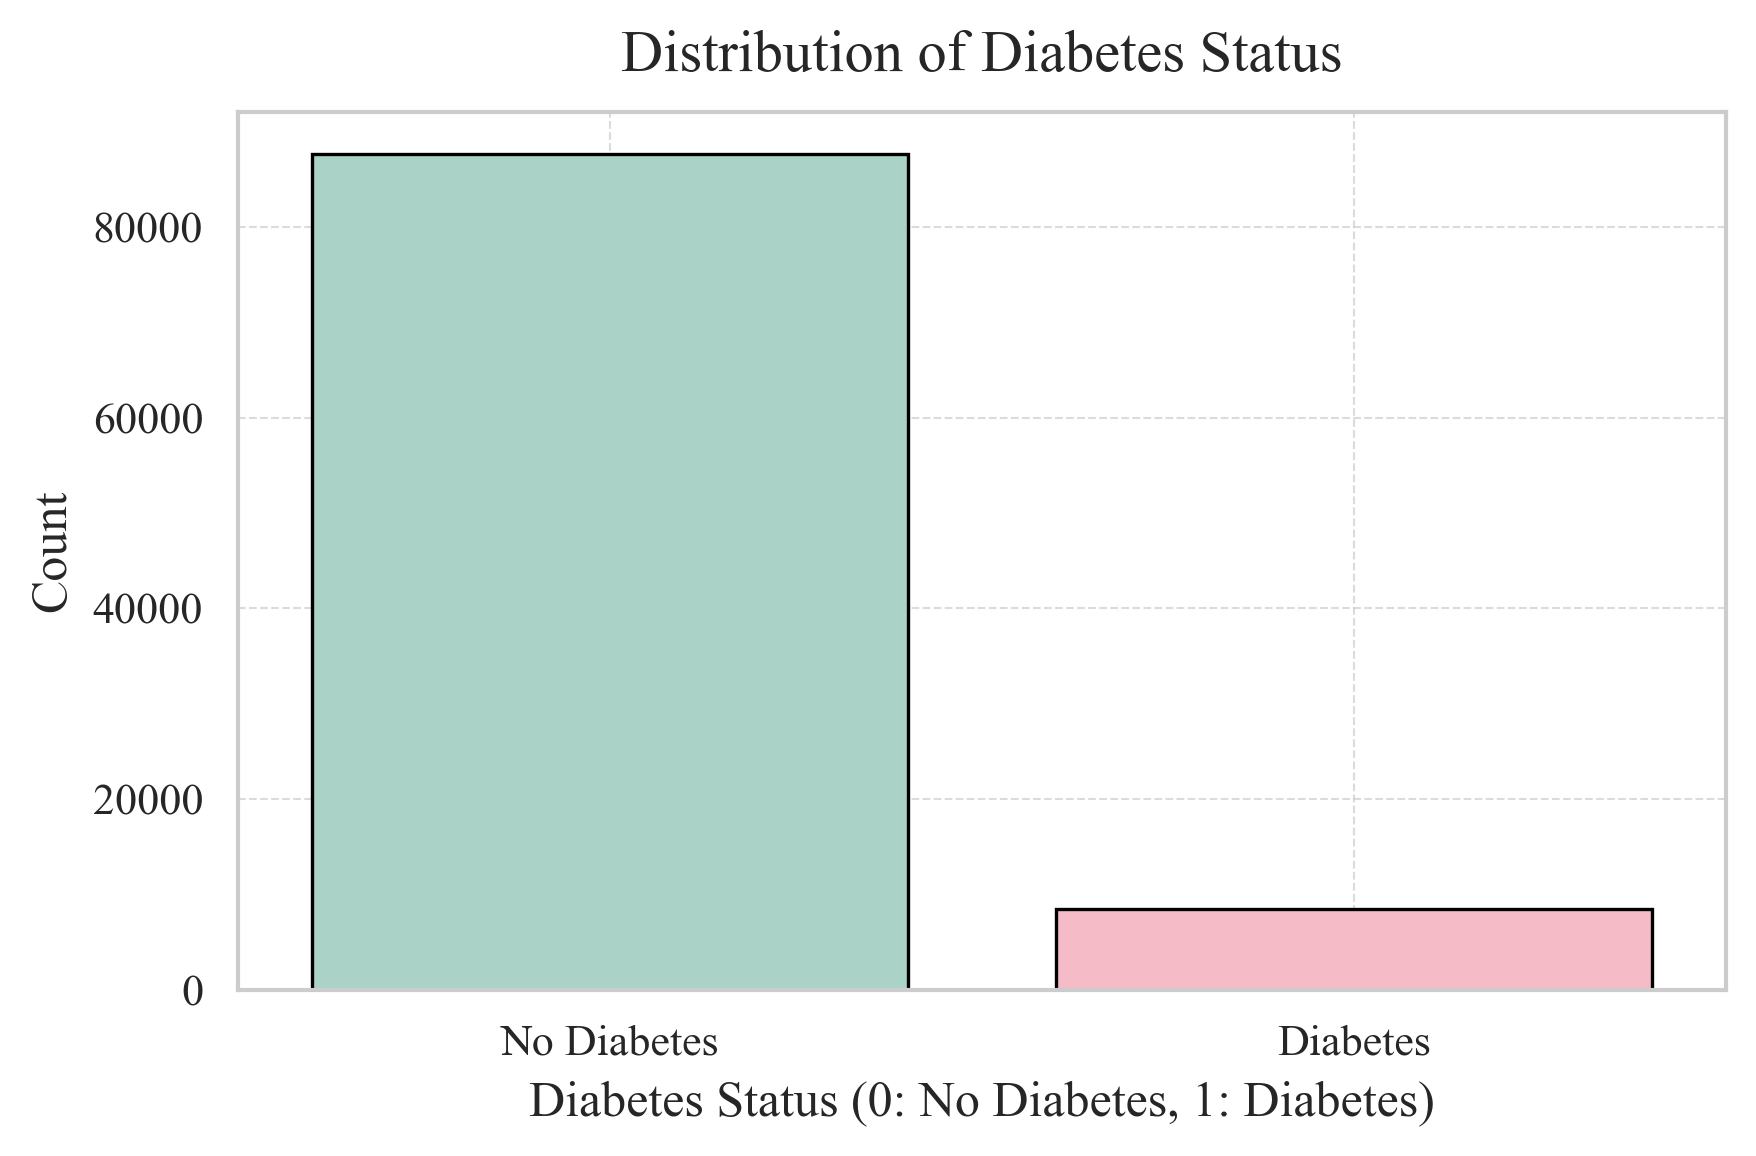

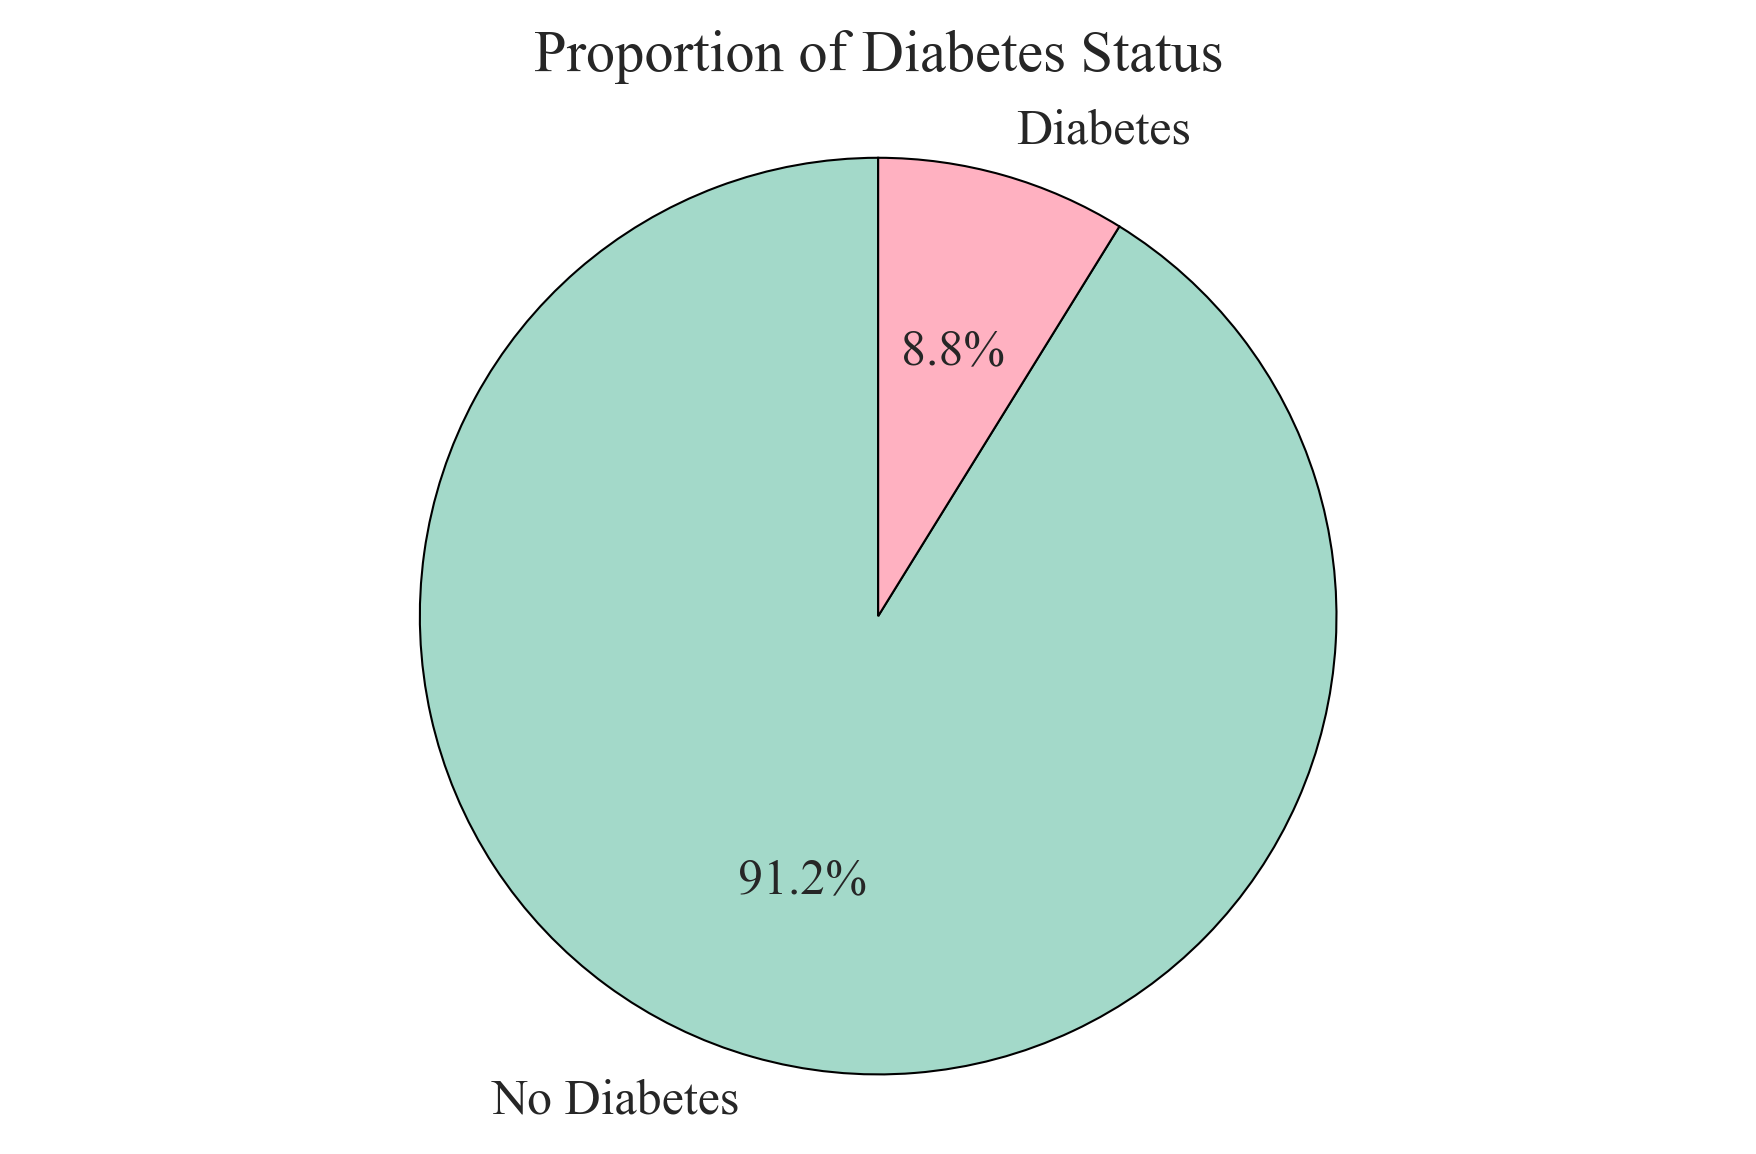

In [43]:
# Установка шрифта Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12  # Базовый размер шрифта для согласованности

# Установка стиля для научной статьи
sns.set_theme(style='whitegrid', context='paper', font='Times New Roman', font_scale=1.2)

# Холодные цвета: мятный зелёный для "без диабета" (0), холодный розовый для "с диабетом" (1)
colors = ['#a3d9c9', '#ffb1c1']  # Холодный мятный зелёный и холодный розовый

# Предполагается, что df уже загружен (например, df = pd.read_csv('diabetes_dataset.csv'))
# Bar chart (столбчатая диаграмма)
plt.figure(figsize=(6, 4), dpi=300)  # Высокое разрешение для чёткости
sns.countplot(x='diabetes', data=df, palette=colors, edgecolor='black')
plt.title('Distribution of Diabetes Status', fontsize=14, pad=10)
plt.xlabel('Diabetes Status (0: No Diabetes, 1: Diabetes)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(ticks=[0, 1], labels=['No Diabetes', 'Diabetes'])
plt.tight_layout()
plt.savefig('diabetes_bar_chart.png', dpi=300, bbox_inches='tight', format='png')  # Сохранение в высоком качестве
plt.show()

# Pie chart (круговая диаграмма)
plt.figure(figsize=(6, 4), dpi=300)  # Высокое разрешение для чёткости
diabetes_counts = df['diabetes'].value_counts()
plt.pie(diabetes_counts, labels=['No Diabetes', 'Diabetes'], colors=colors, autopct='%1.1f%%',
        startangle=90, wedgeprops={'edgecolor': 'black', 'linewidth': 0.5}, textprops={'fontsize': 12})
plt.title('Proportion of Diabetes Status', fontsize=14, pad=10)
plt.axis('equal')  # Равные пропорции для круга
plt.tight_layout()
plt.savefig('diabetes_pie_chart.png', dpi=300, bbox_inches='tight', format='png')  # Сохранение в высоком качестве
plt.show()

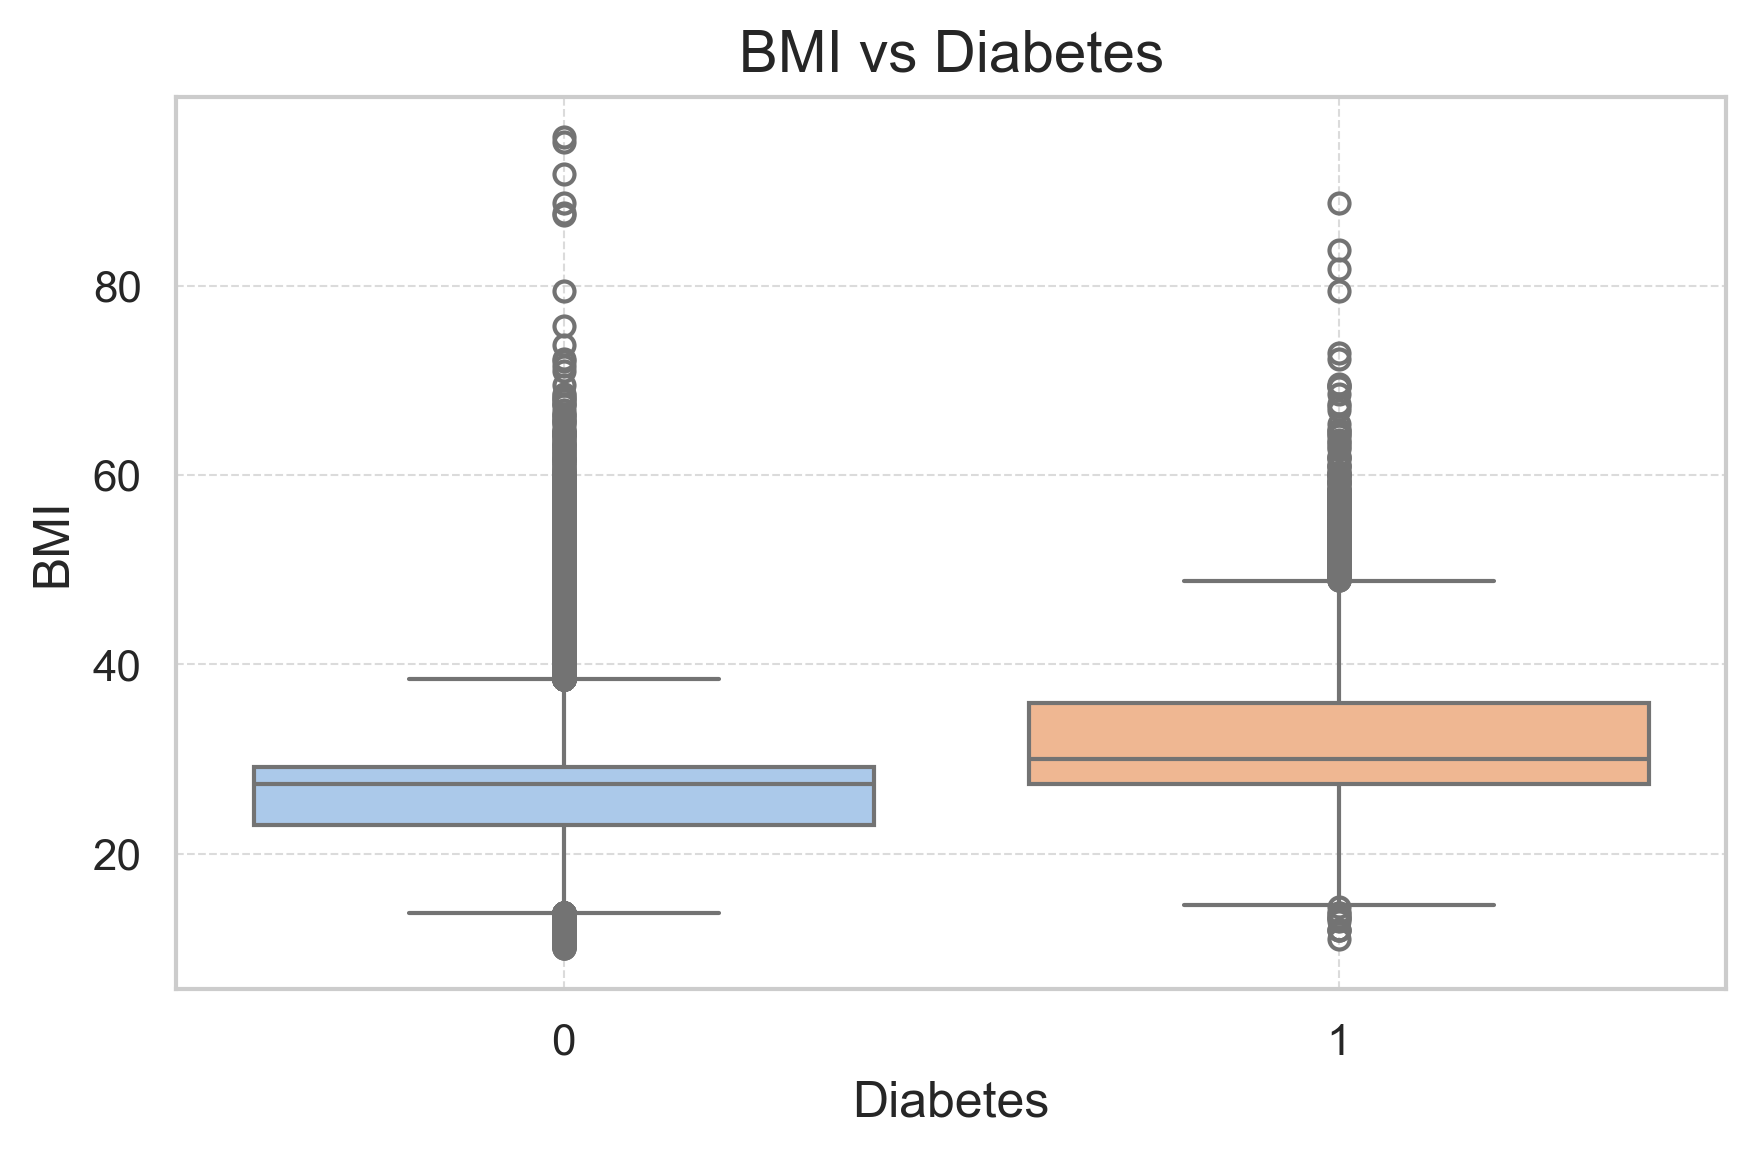

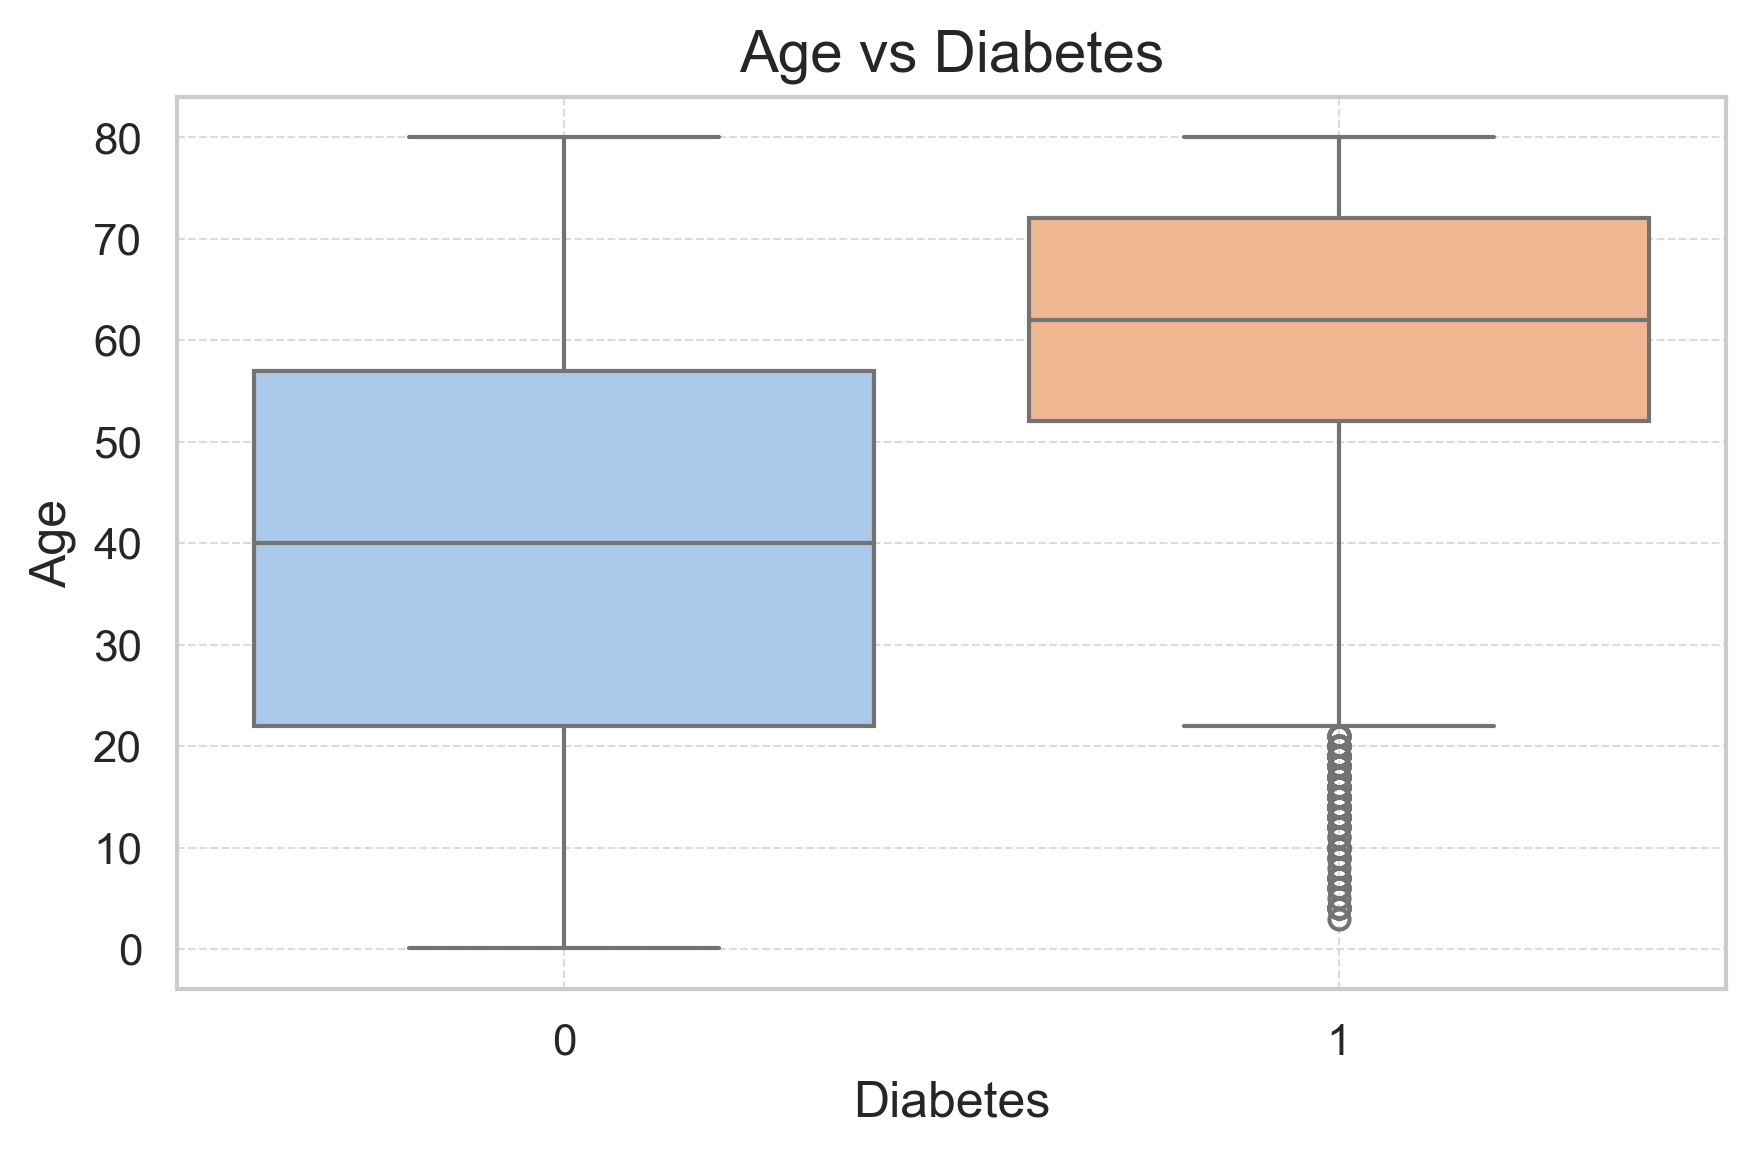

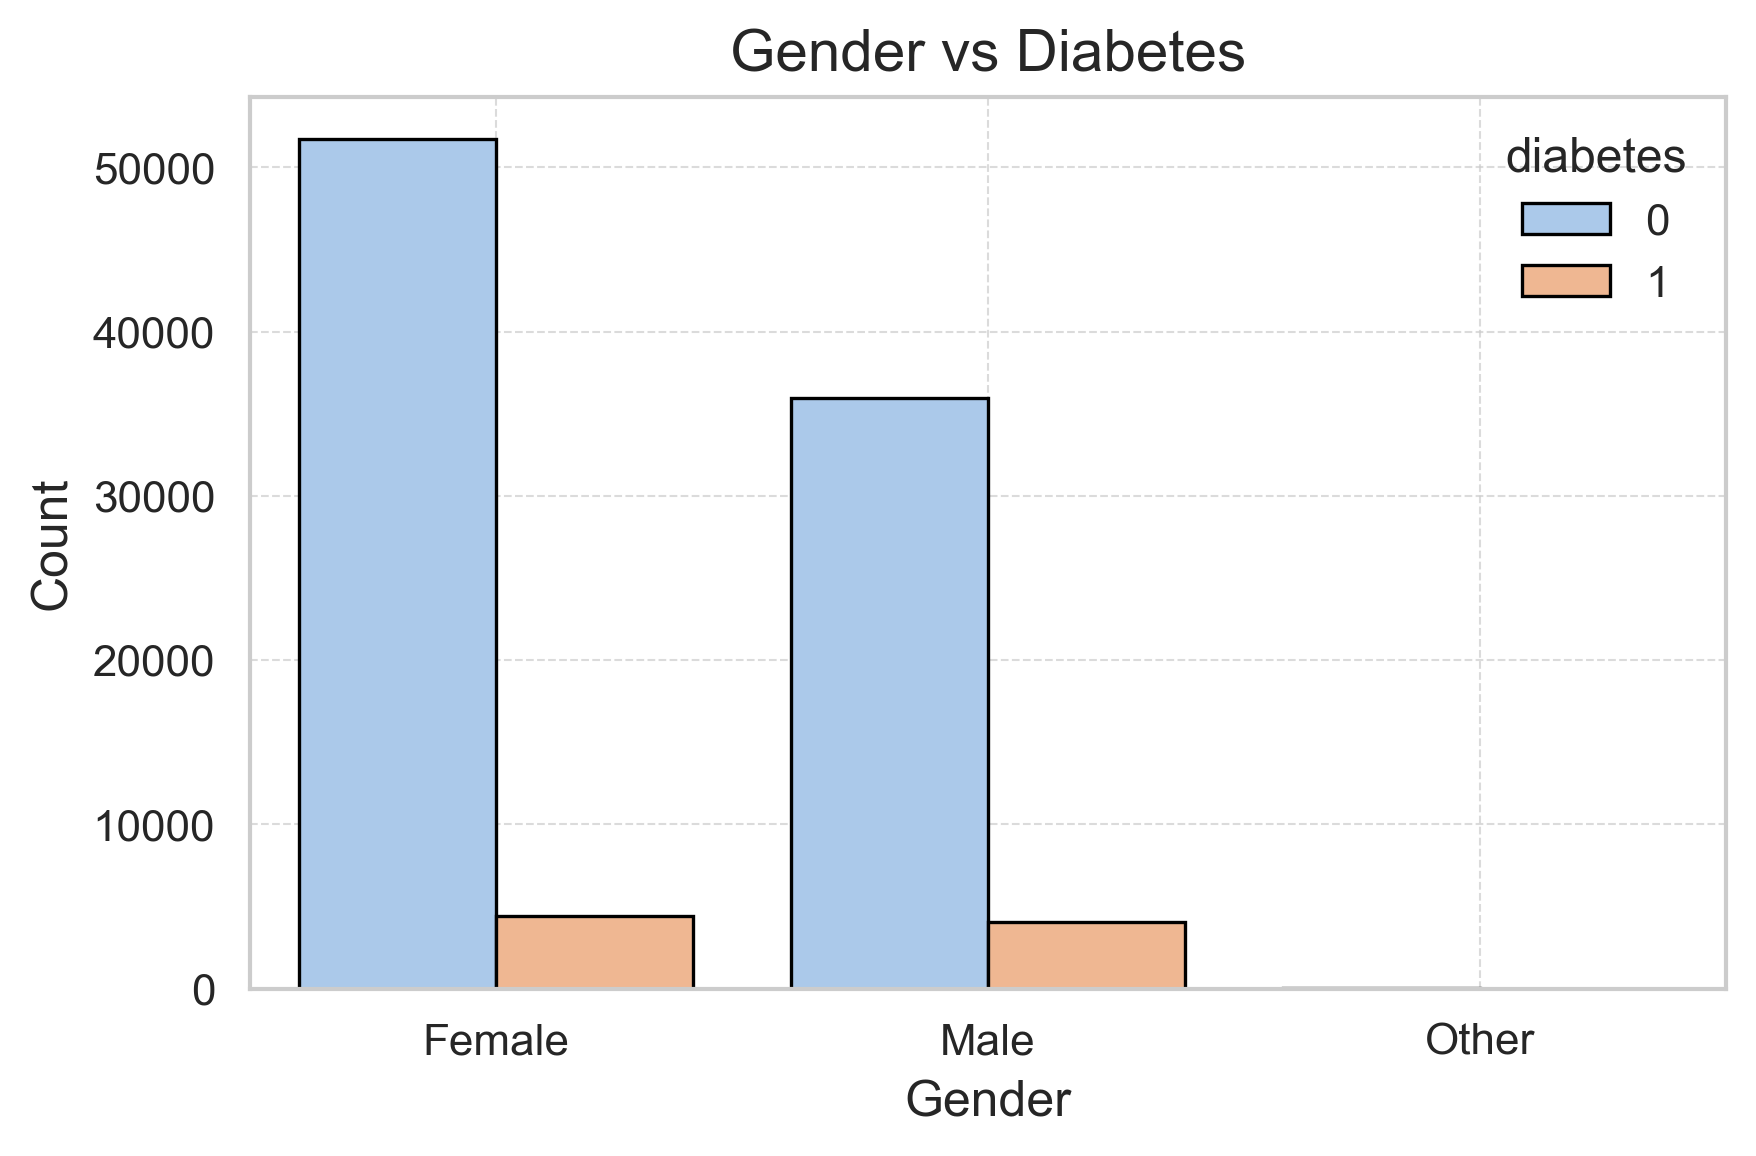

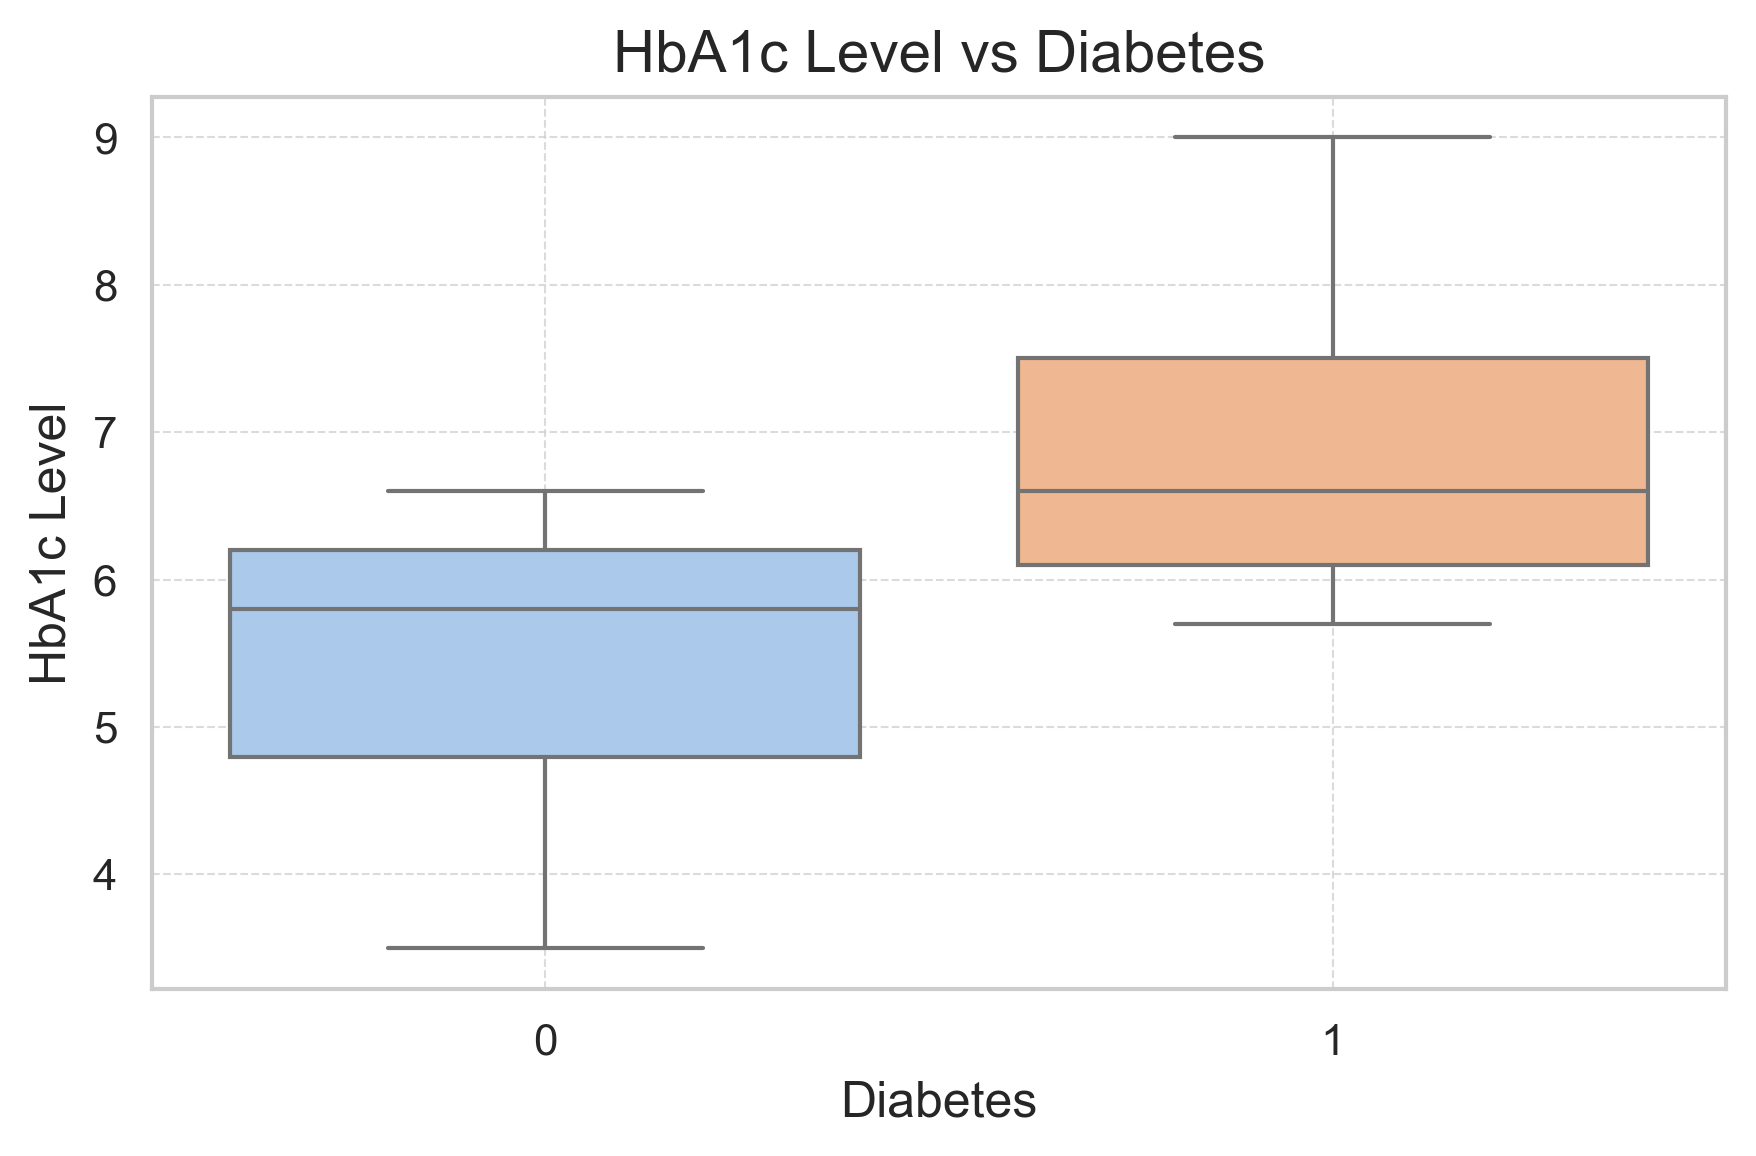

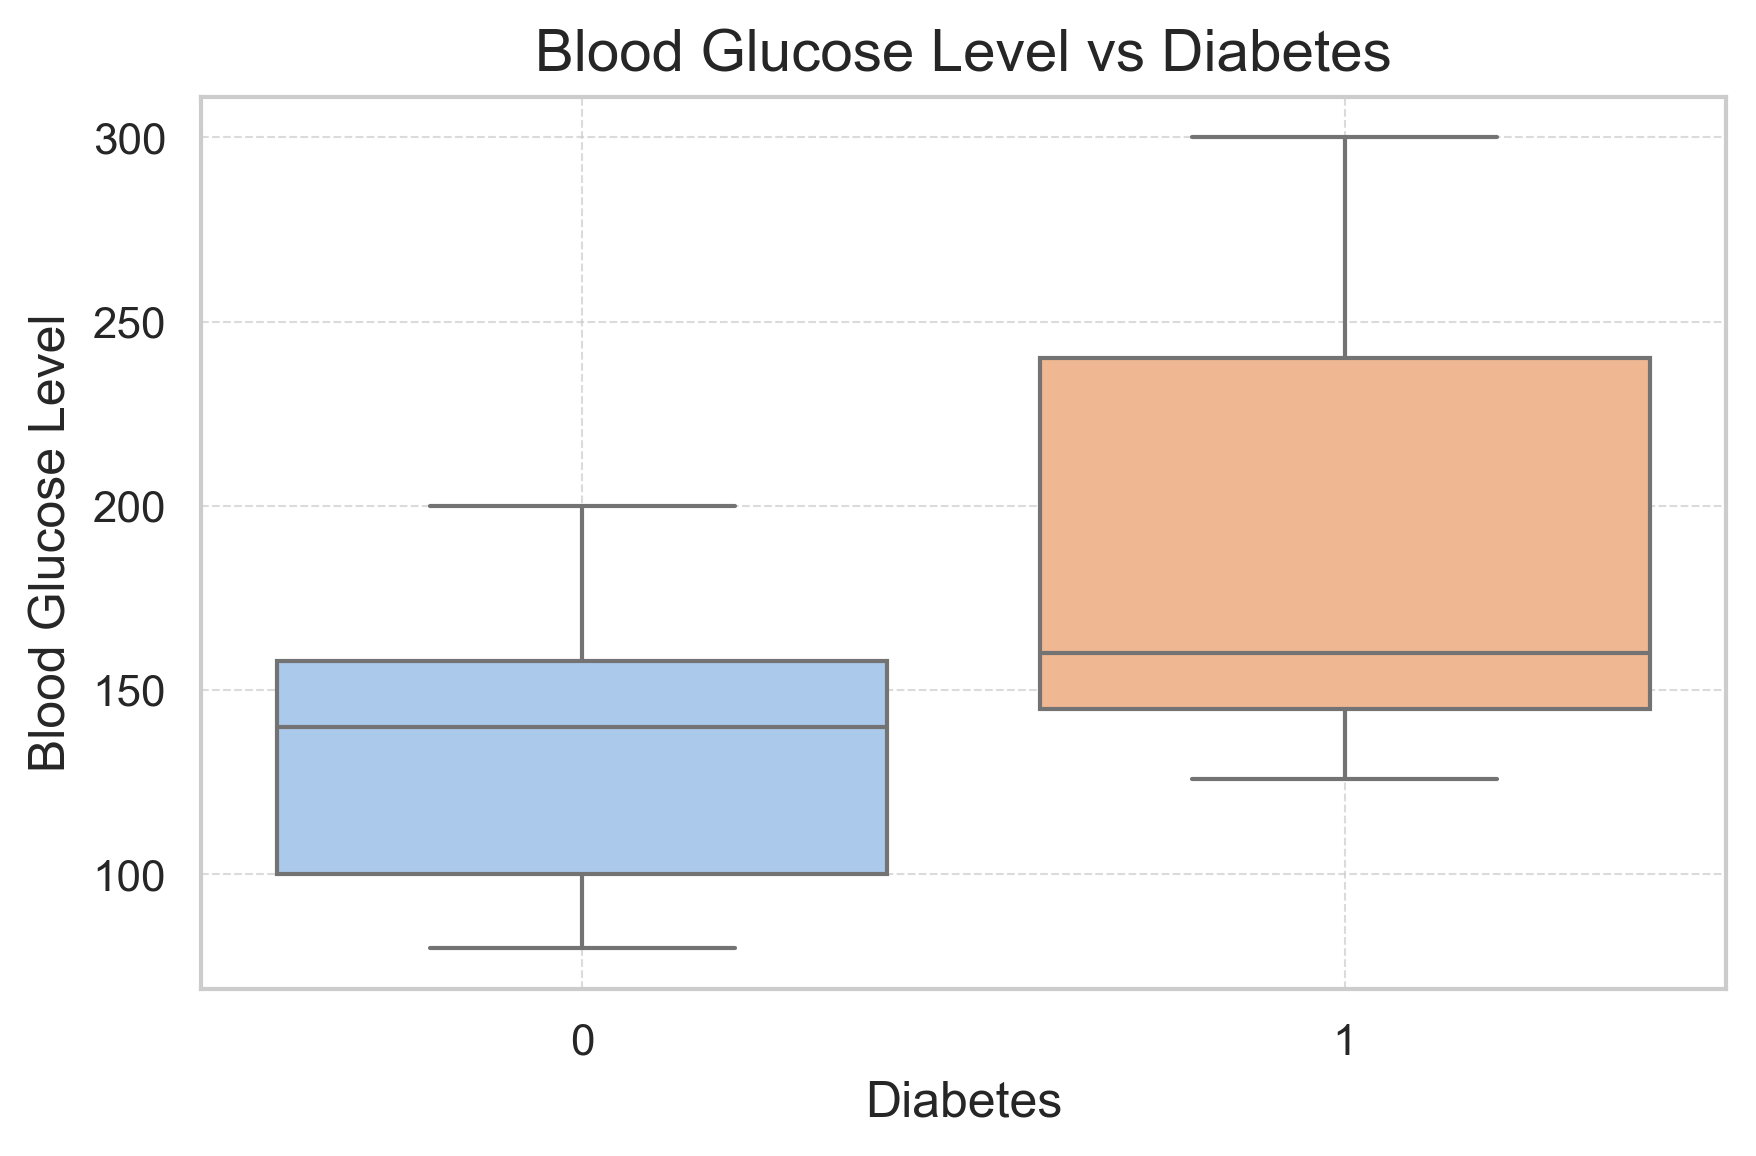

In [45]:
# BIVARIATE ANALYSIS
sns.set_style("whitegrid")
plt.rcParams.update({'axes.titlesize': 14, 'axes.labelsize': 12})

custom_palette = ['#a1c9f4', '#ffb482']  

# --- Boxplot: BMI vs Diabetes ---
plt.figure(figsize=(6, 4))
sns.boxplot(x='diabetes', y='bmi', data=df, palette=custom_palette)
plt.title('BMI vs Diabetes')
plt.xlabel('Diabetes')
plt.ylabel('BMI')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

# --- Boxplot: Age vs Diabetes ---
plt.figure(figsize=(6, 4))
sns.boxplot(x='diabetes', y='age', data=df, palette=custom_palette)
plt.title('Age vs Diabetes')
plt.xlabel('Diabetes')
plt.ylabel('Age')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

# --- Countplot: Gender vs Diabetes (hue) ---
plt.figure(figsize=(6, 4))
sns.countplot(x='gender', hue='diabetes', data=df, palette=custom_palette, edgecolor='black')
plt.title('Gender vs Diabetes')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

# --- Boxplot: HbA1c level vs Diabetes ---
plt.figure(figsize=(6, 4))
sns.boxplot(x='diabetes', y='HbA1c_level', data=df, palette=custom_palette)
plt.title('HbA1c Level vs Diabetes')
plt.xlabel('Diabetes')
plt.ylabel('HbA1c Level')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

# --- Boxplot: Blood Glucose Level vs Diabetes ---
plt.figure(figsize=(6, 4))
sns.boxplot(x='diabetes', y='blood_glucose_level', data=df, palette=custom_palette)
plt.title('Blood Glucose Level vs Diabetes')
plt.xlabel('Diabetes')
plt.ylabel('Blood Glucose Level')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

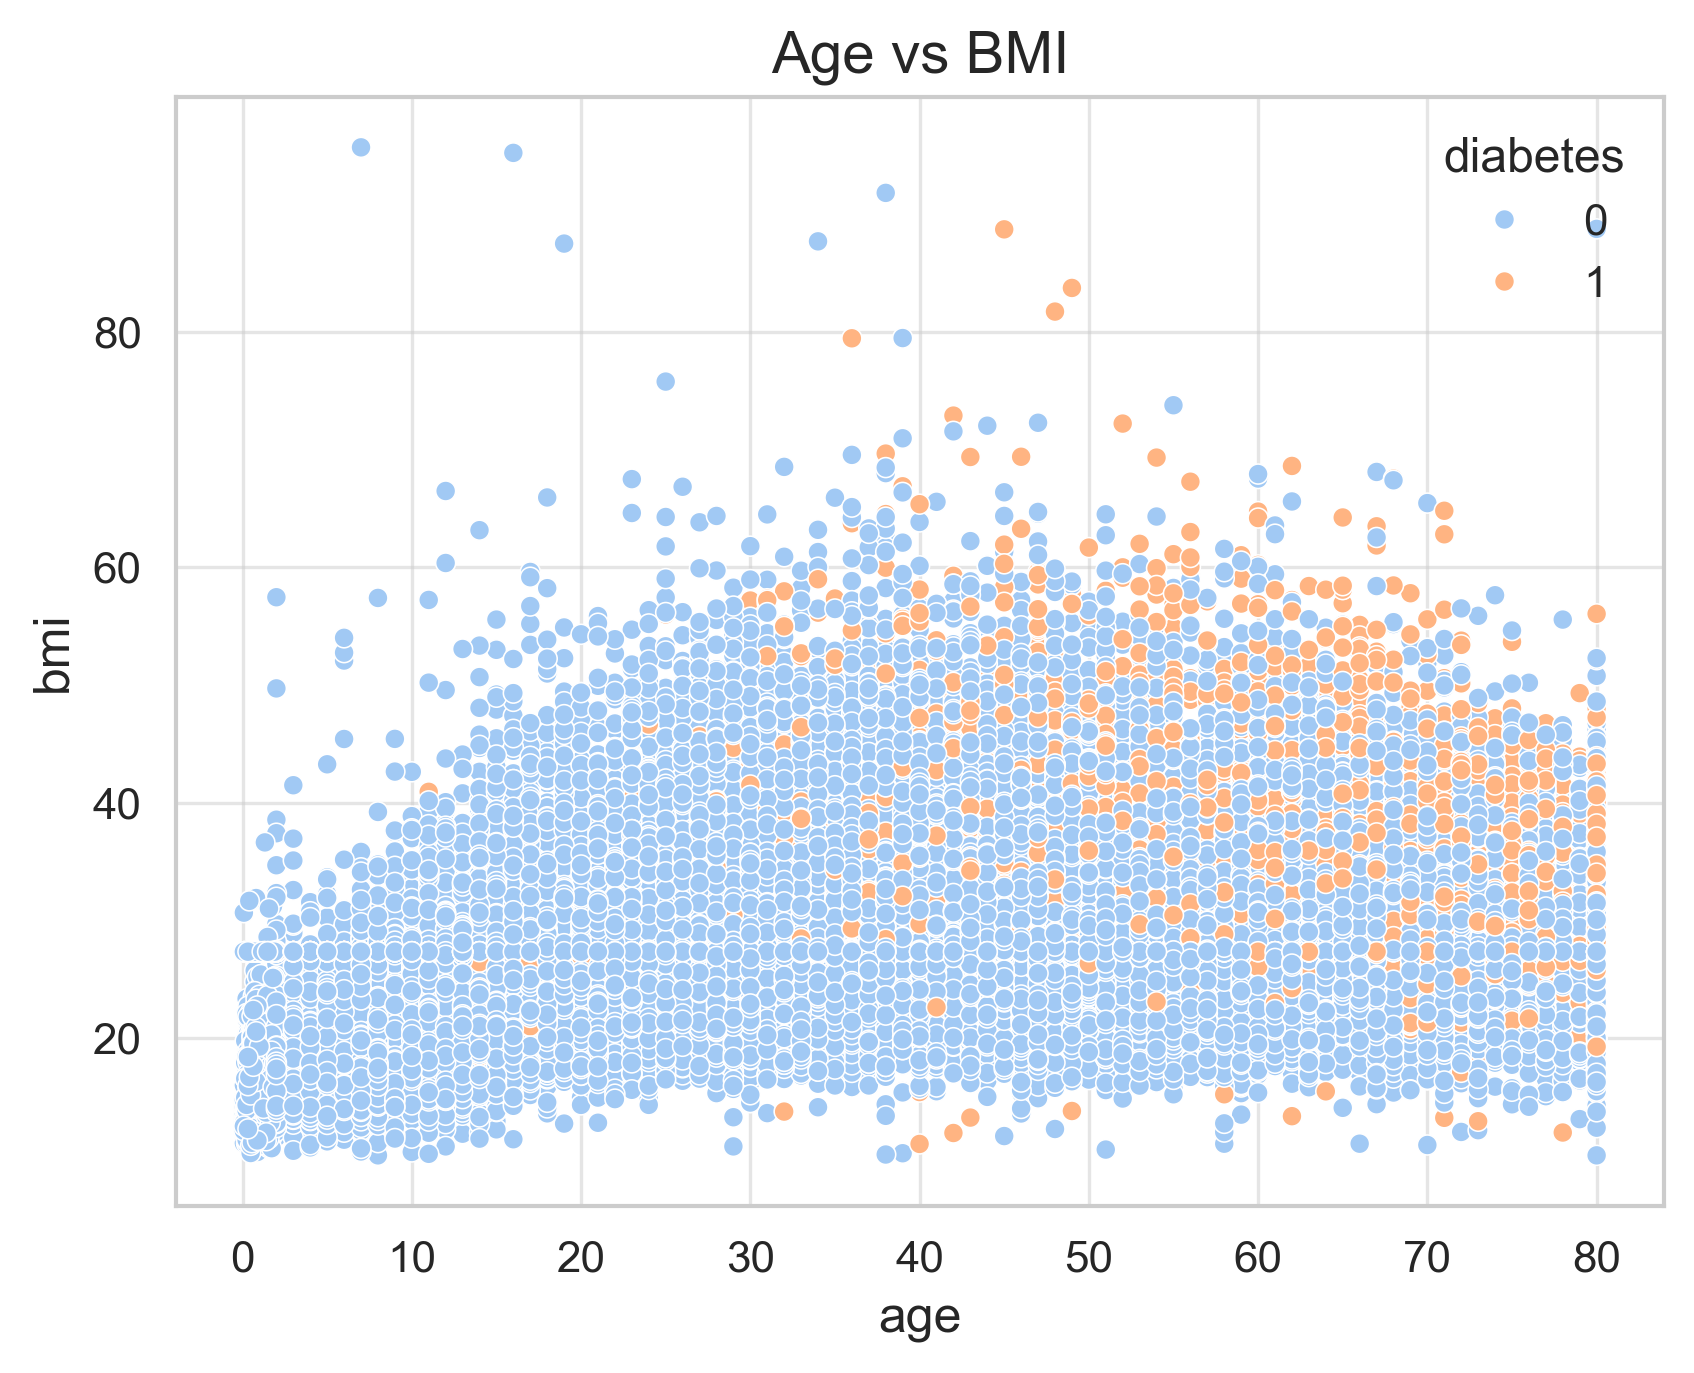

In [46]:
#MULTIVARIATE ANALYSIS 
# Scatterplot Age vs BMI colored by Diabetes classification
custom_palette = ['#a1c9f4', '#ffb482']  
sns.scatterplot(x='age', y='bmi', hue='diabetes', data=df, palette=custom_palette)
plt.title('Age vs BMI')
plt.show()

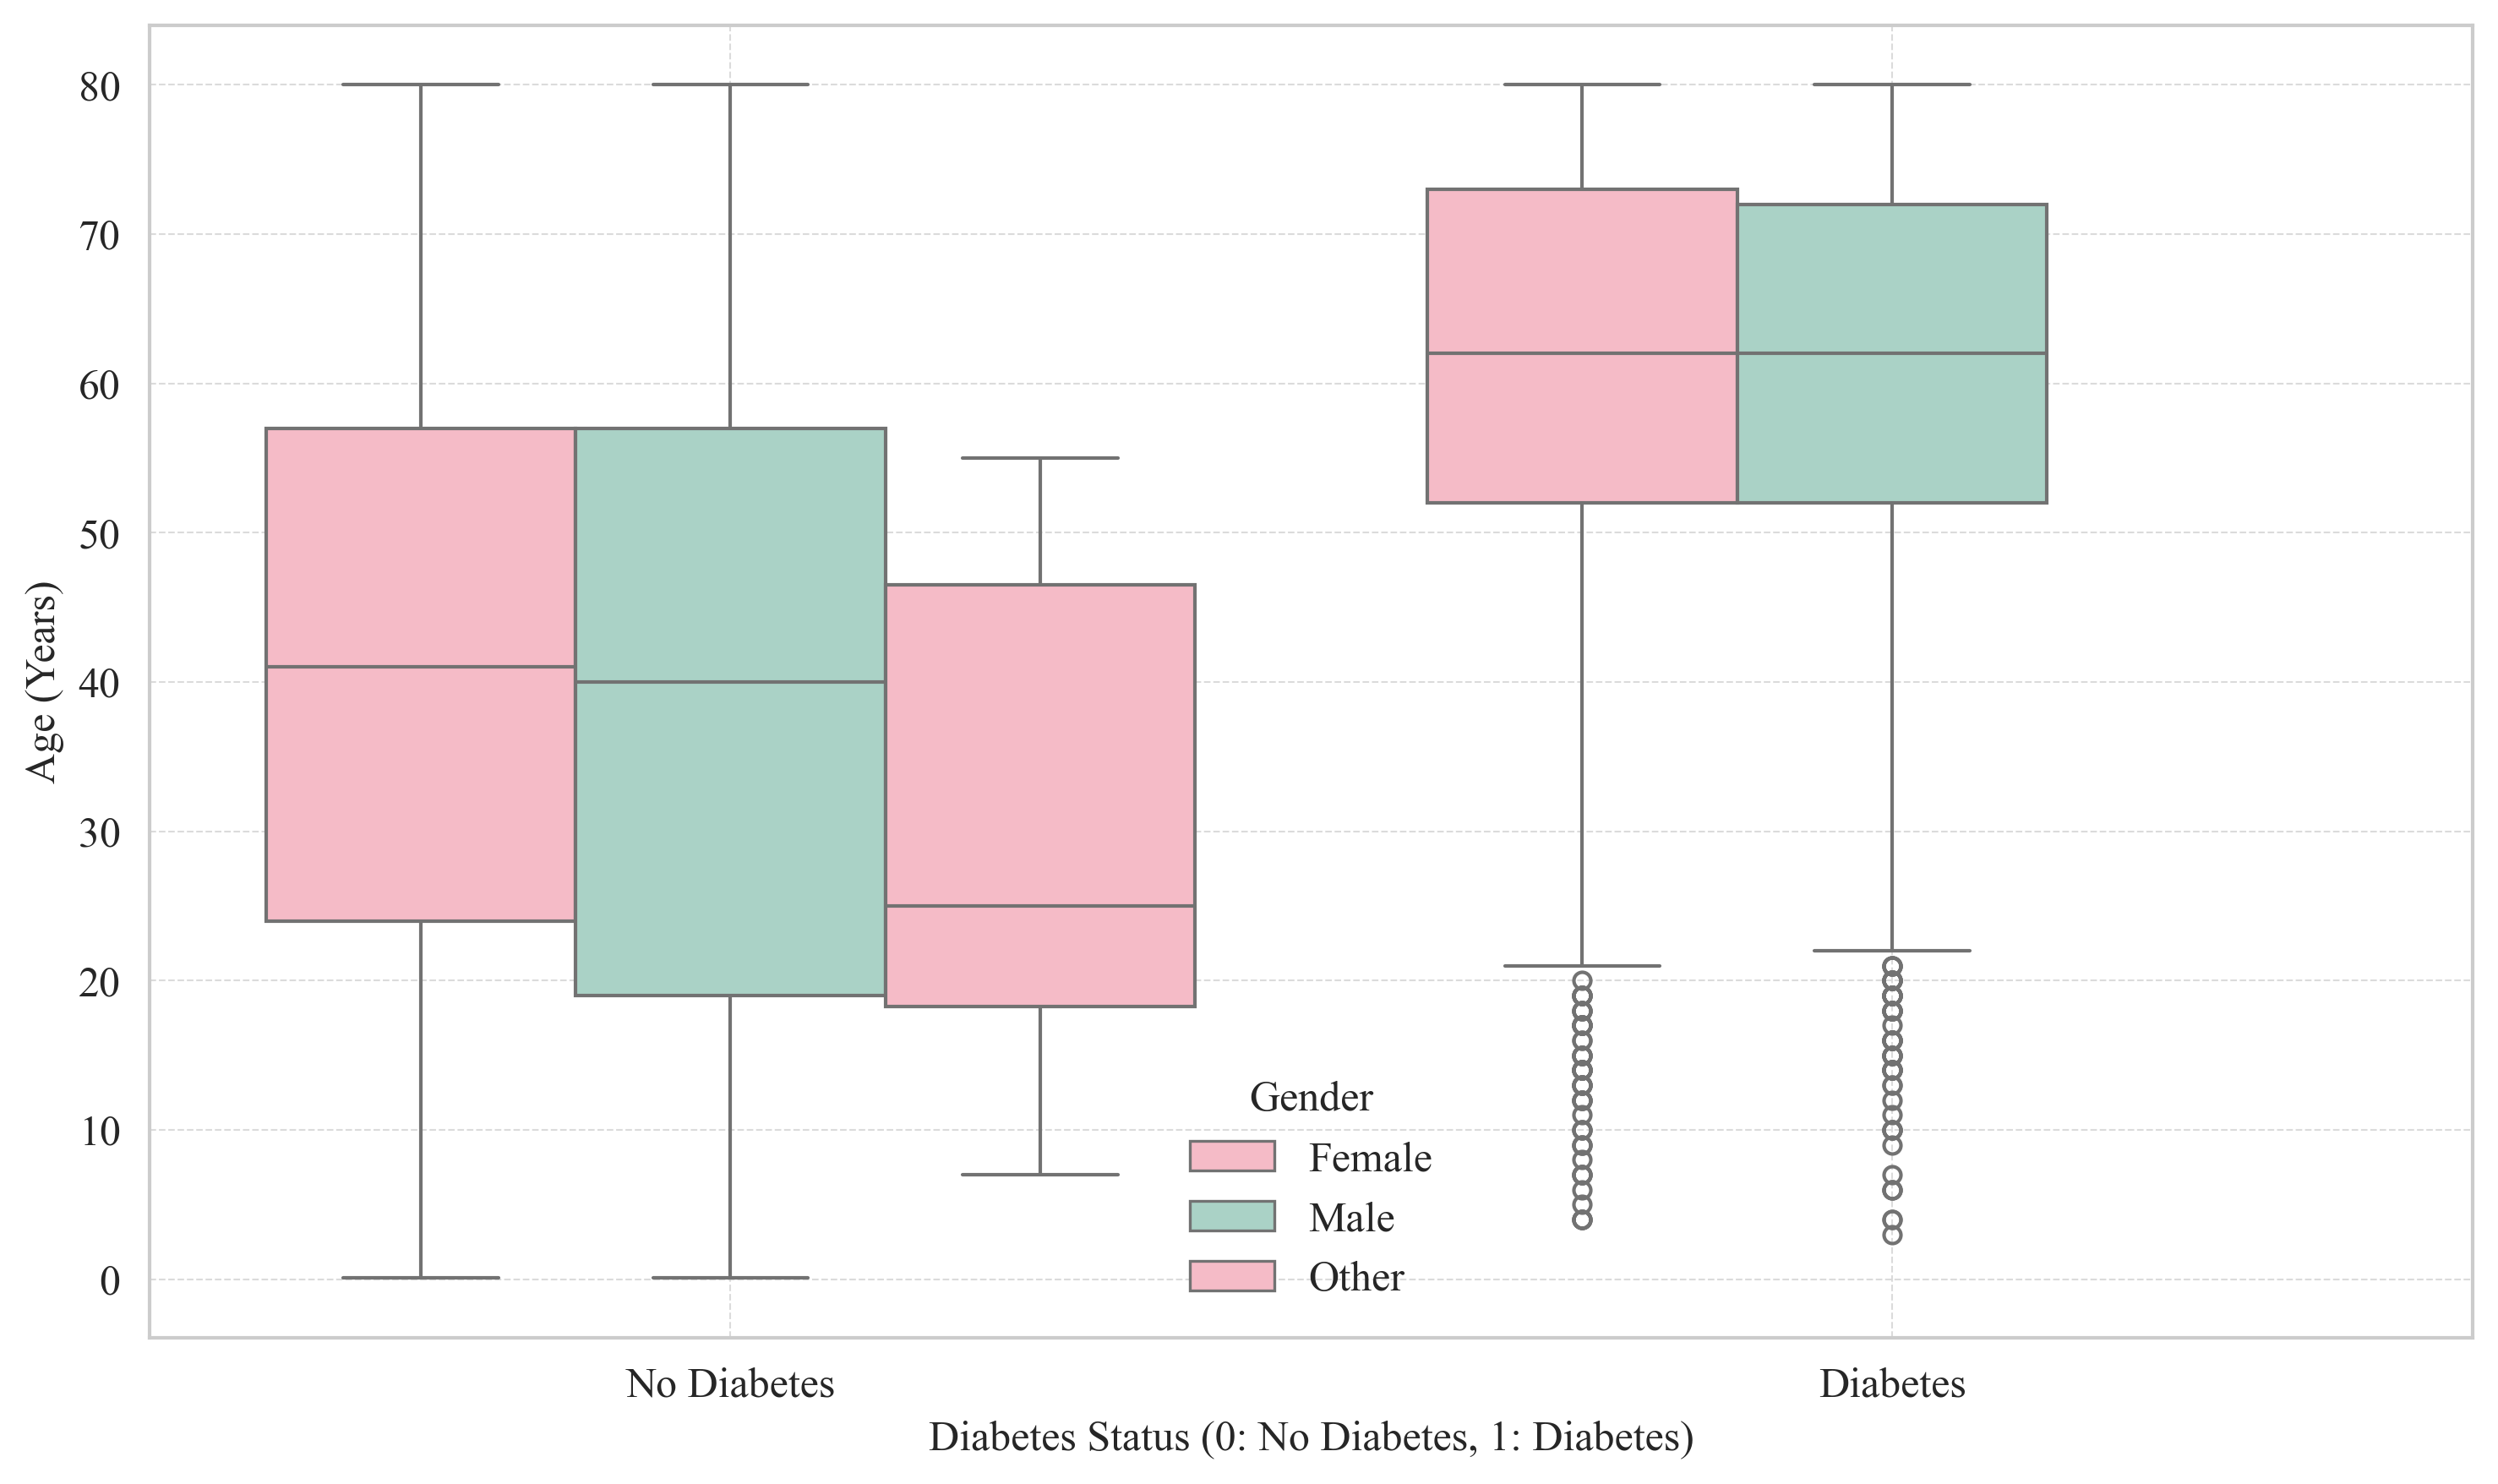

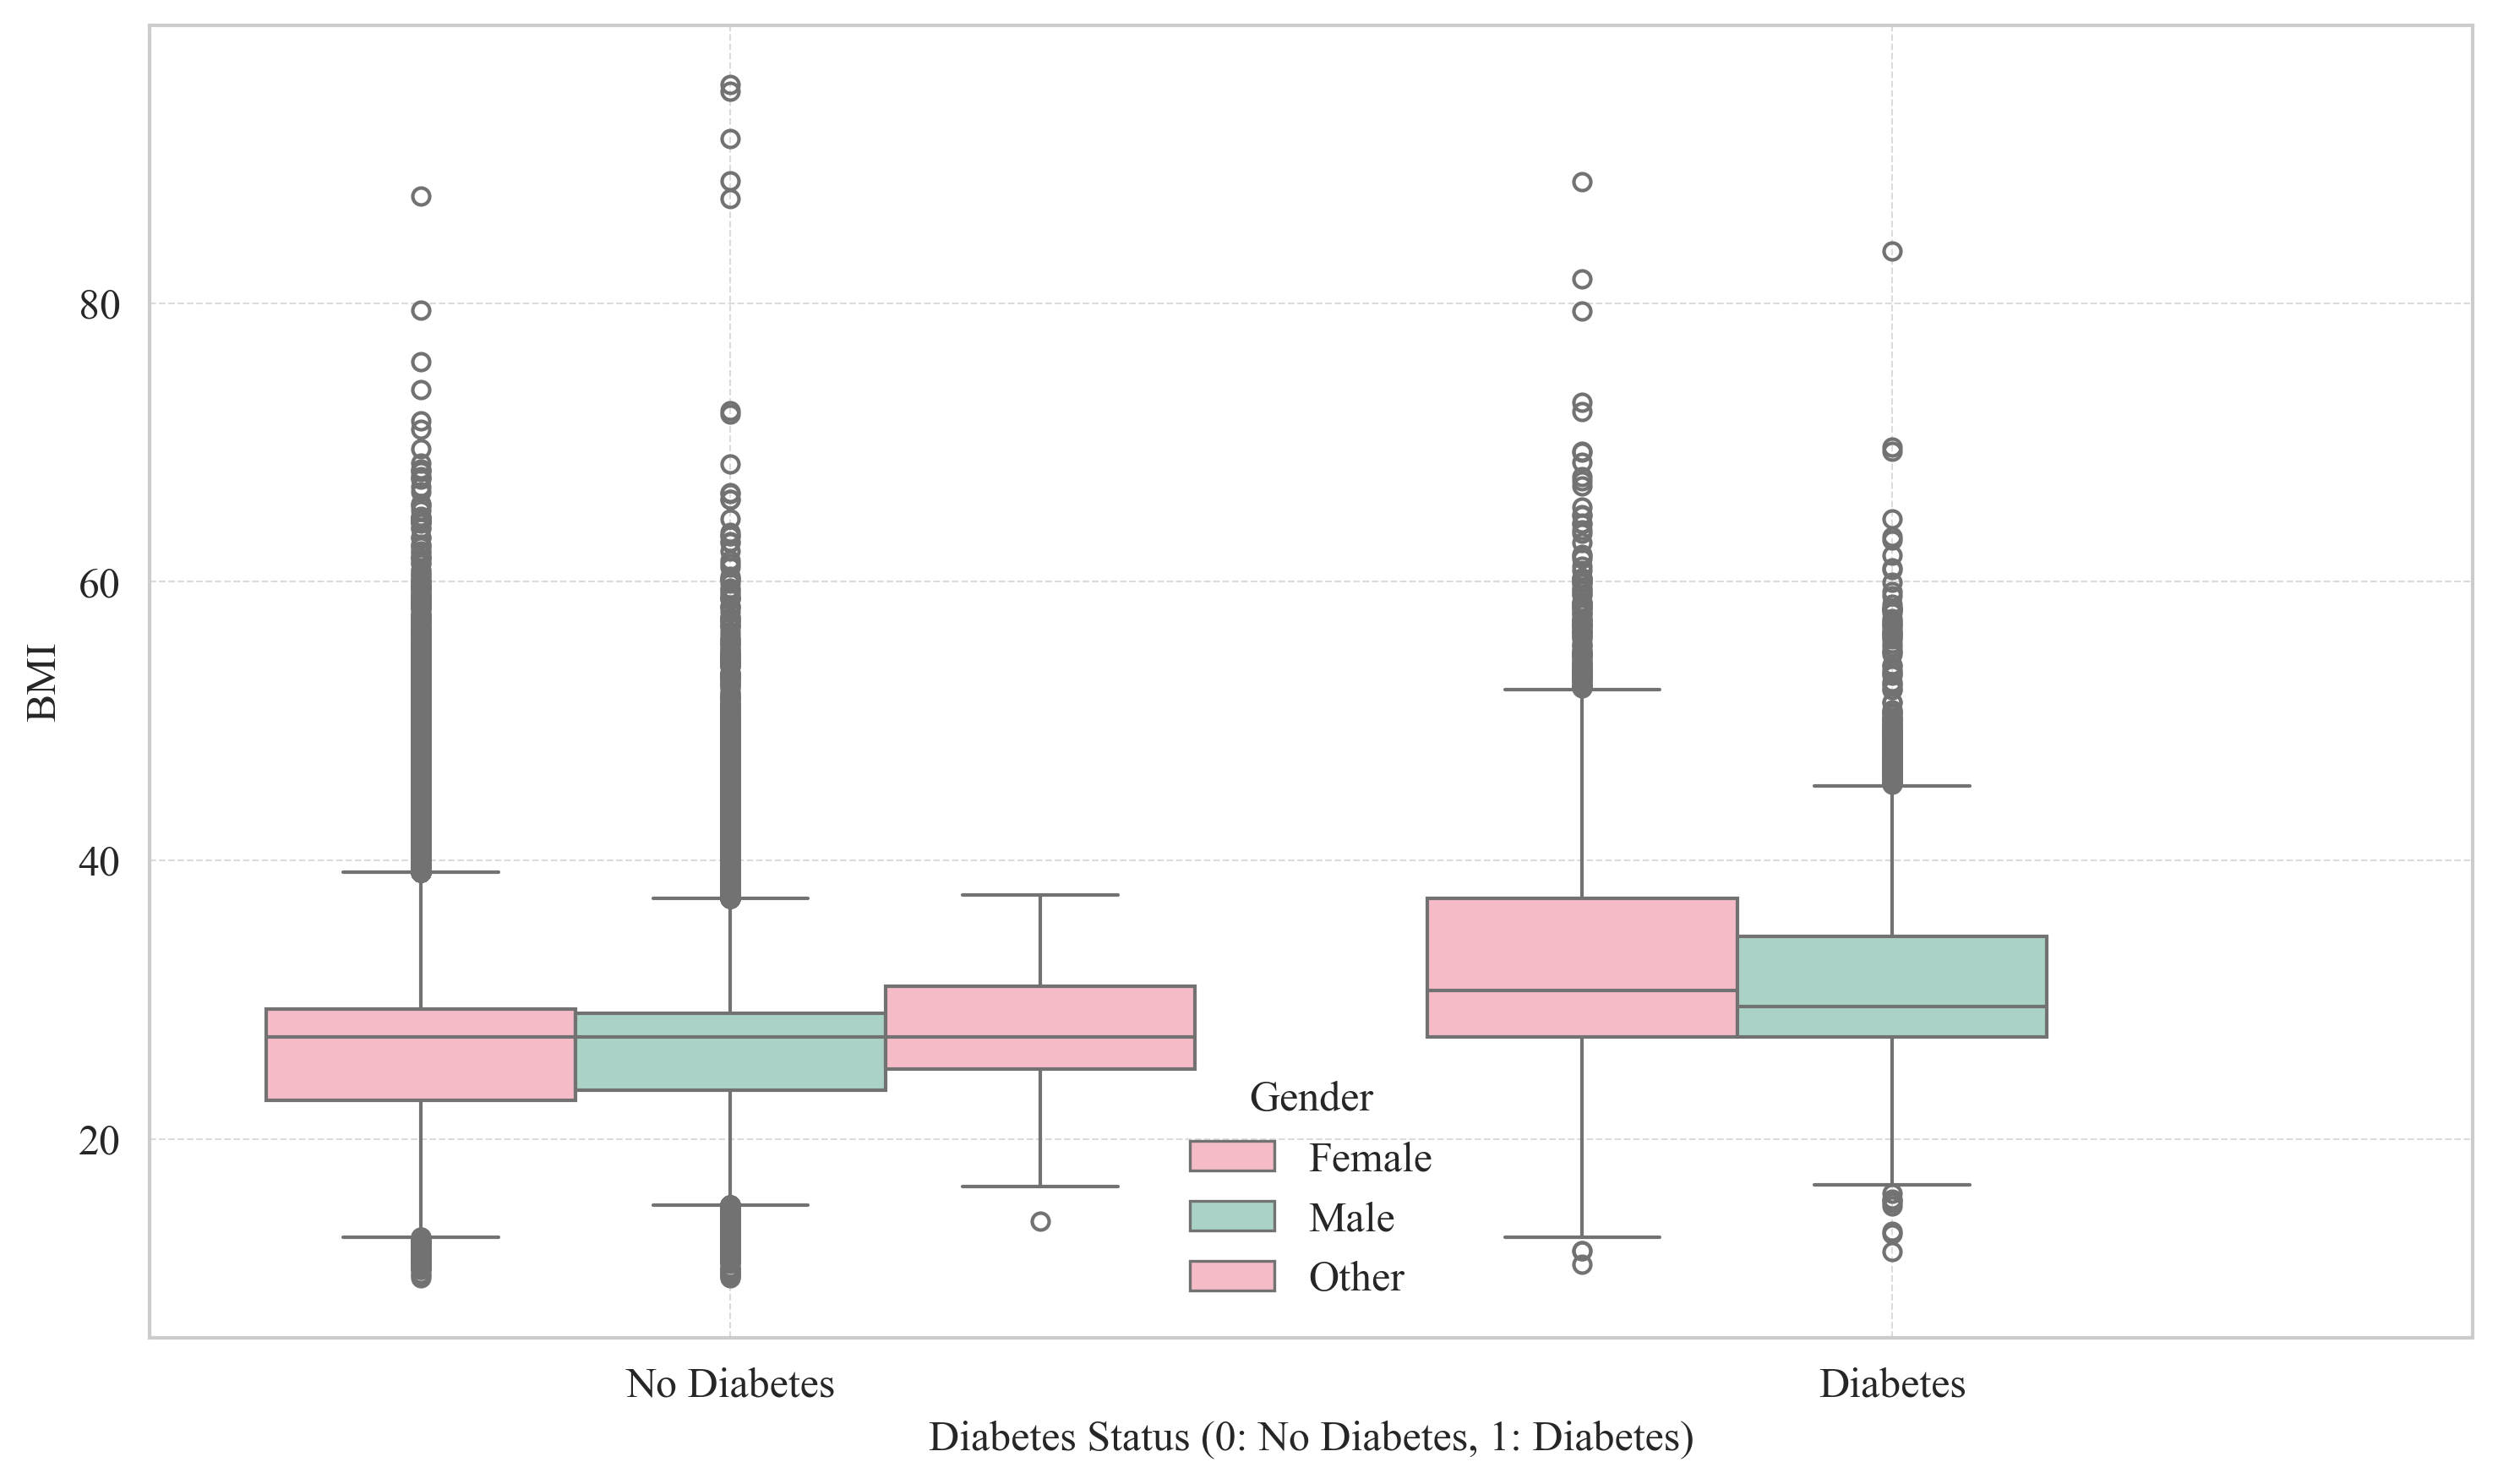

In [48]:
# Установка шрифта Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12  # Базовый размер шрифта

# Установка стиля для научной статьи
sns.set_theme(style='whitegrid', context='paper', font='Times New Roman', font_scale=1.2)

# Холодные пастельные цвета: мятный зелёный для мужчин, холодный розовый для женщин
custom_palette = ['#ffb1c1', '#a3d9c9']  # Мужчины, женщины

# Предполагается, что df уже загружен (например, df = pd.read_csv('diabetes_dataset.csv'))
# Boxplot: Age Distribution by Diabetes Status and Gender
plt.figure(figsize=(10, 6), dpi=300)  # Большой размер (10x6 дюймов) и высокое разрешение
sns.boxplot(x='diabetes', y='age', hue='gender', data=df, palette=custom_palette)
plt.xlabel('Diabetes Status (0: No Diabetes, 1: Diabetes)', fontsize=12)
plt.ylabel('Age (Years)', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['No Diabetes', 'Diabetes'], fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Gender', fontsize=12, title_fontsize=12, loc='lower center')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig('boxplot_age_diabetes_gender.png', dpi=300, bbox_inches='tight', format='png')
plt.show()

# Boxplot: BMI Distribution by Diabetes Status and Gender
plt.figure(figsize=(10, 6), dpi=300)  # Большой размер (10x6 дюймов) и высокое разрешение
sns.boxplot(x='diabetes', y='bmi', hue='gender', data=df, palette=custom_palette)
plt.xlabel('Diabetes Status (0: No Diabetes, 1: Diabetes)', fontsize=12)
plt.ylabel('BMI', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['No Diabetes', 'Diabetes'], fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Gender', fontsize=12, title_fontsize=12, loc='lower center')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig('boxplot_bmi_diabetes_gender.png', dpi=300, bbox_inches='tight', format='png')
plt.show()

In [51]:
def sigmoid(z):
  return 1.0 / (1 + np.exp(-z))

In [56]:
#CORRELATION
# Define a function to map the existing categories to new ones
def recategorize_smoking(smoking_status):
    if smoking_status in ['never', 'No Info']:
        return 'non-smoker'
    elif smoking_status == 'current':
        return 'current'
    elif smoking_status in ['ever', 'former', 'not current']:
        return 'past_smoker'



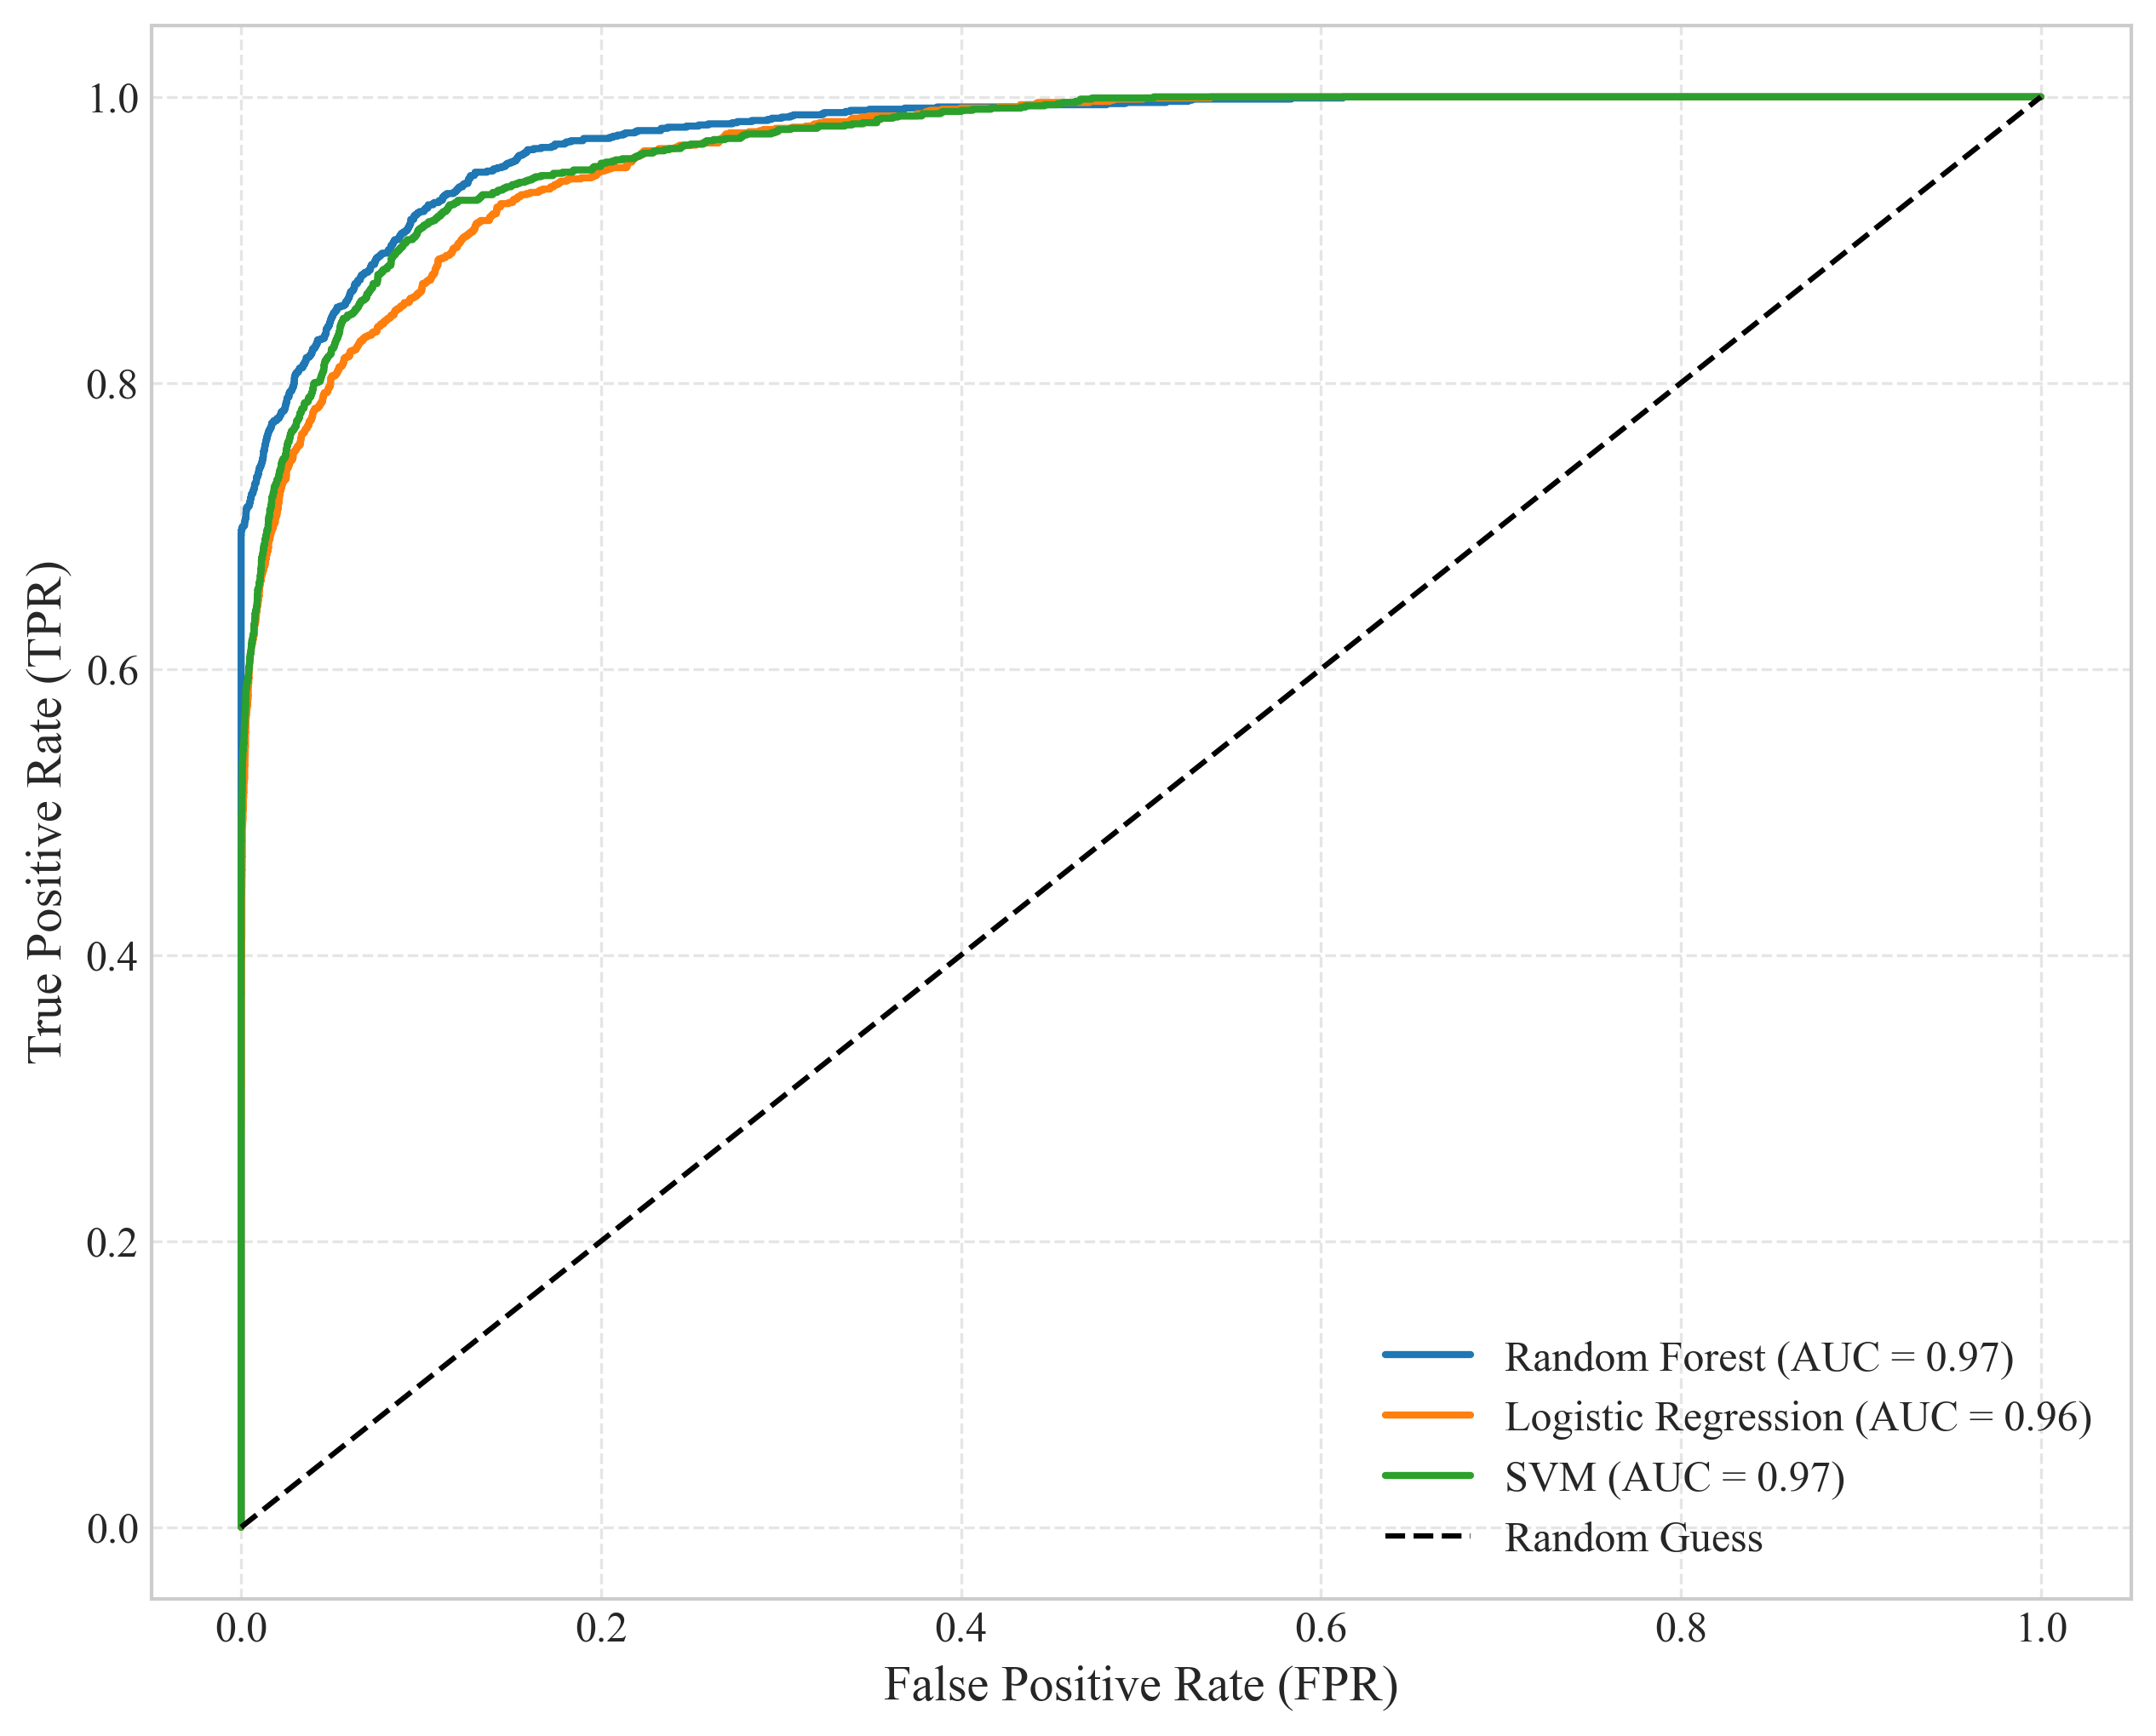

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd
import os

plt.style.use('seaborn-v0_8-whitegrid')  
plt.rcParams.update({
    'font.family': 'Times New Roman',  
    'font.size': 12,  
    'axes.titlesize': 16,  
    'axes.labelsize': 14, 
    'legend.fontsize': 12,  
    'xtick.labelsize': 12,  
    'ytick.labelsize': 12,  
    'figure.dpi': 300,  
    'savefig.dpi': 300,  
    'axes.grid': False,  
})

os.makedirs('figures', exist_ok=True)



# ====== ROC CURVES ======
plt.figure(figsize=(10, 8))
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['y_pred_proba'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', linewidth=1.5)
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)  # Включение сетки для ROC-кривых
plt.savefig('figures/roc_curves.png', bbox_inches='tight', dpi=300)
plt.show()

# ====== F1-SCORE, PRECISION, RECALL ======
metrics_data = {
    'Model': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

for name, res in results.items():
    report = res.get('report', {})  
    metrics_data['Model'].append(name)
    metrics_data['Precision'].append(report.get('1', {}).get('precision', 0))
    metrics_data['Recall'].append(report.get('1', {}).get('recall', 0))
    metrics_data['F1-Score'].append(report.get('1', {}).get('f1-score', 0))

metrics_df = pd.DataFrame(metrics_data)



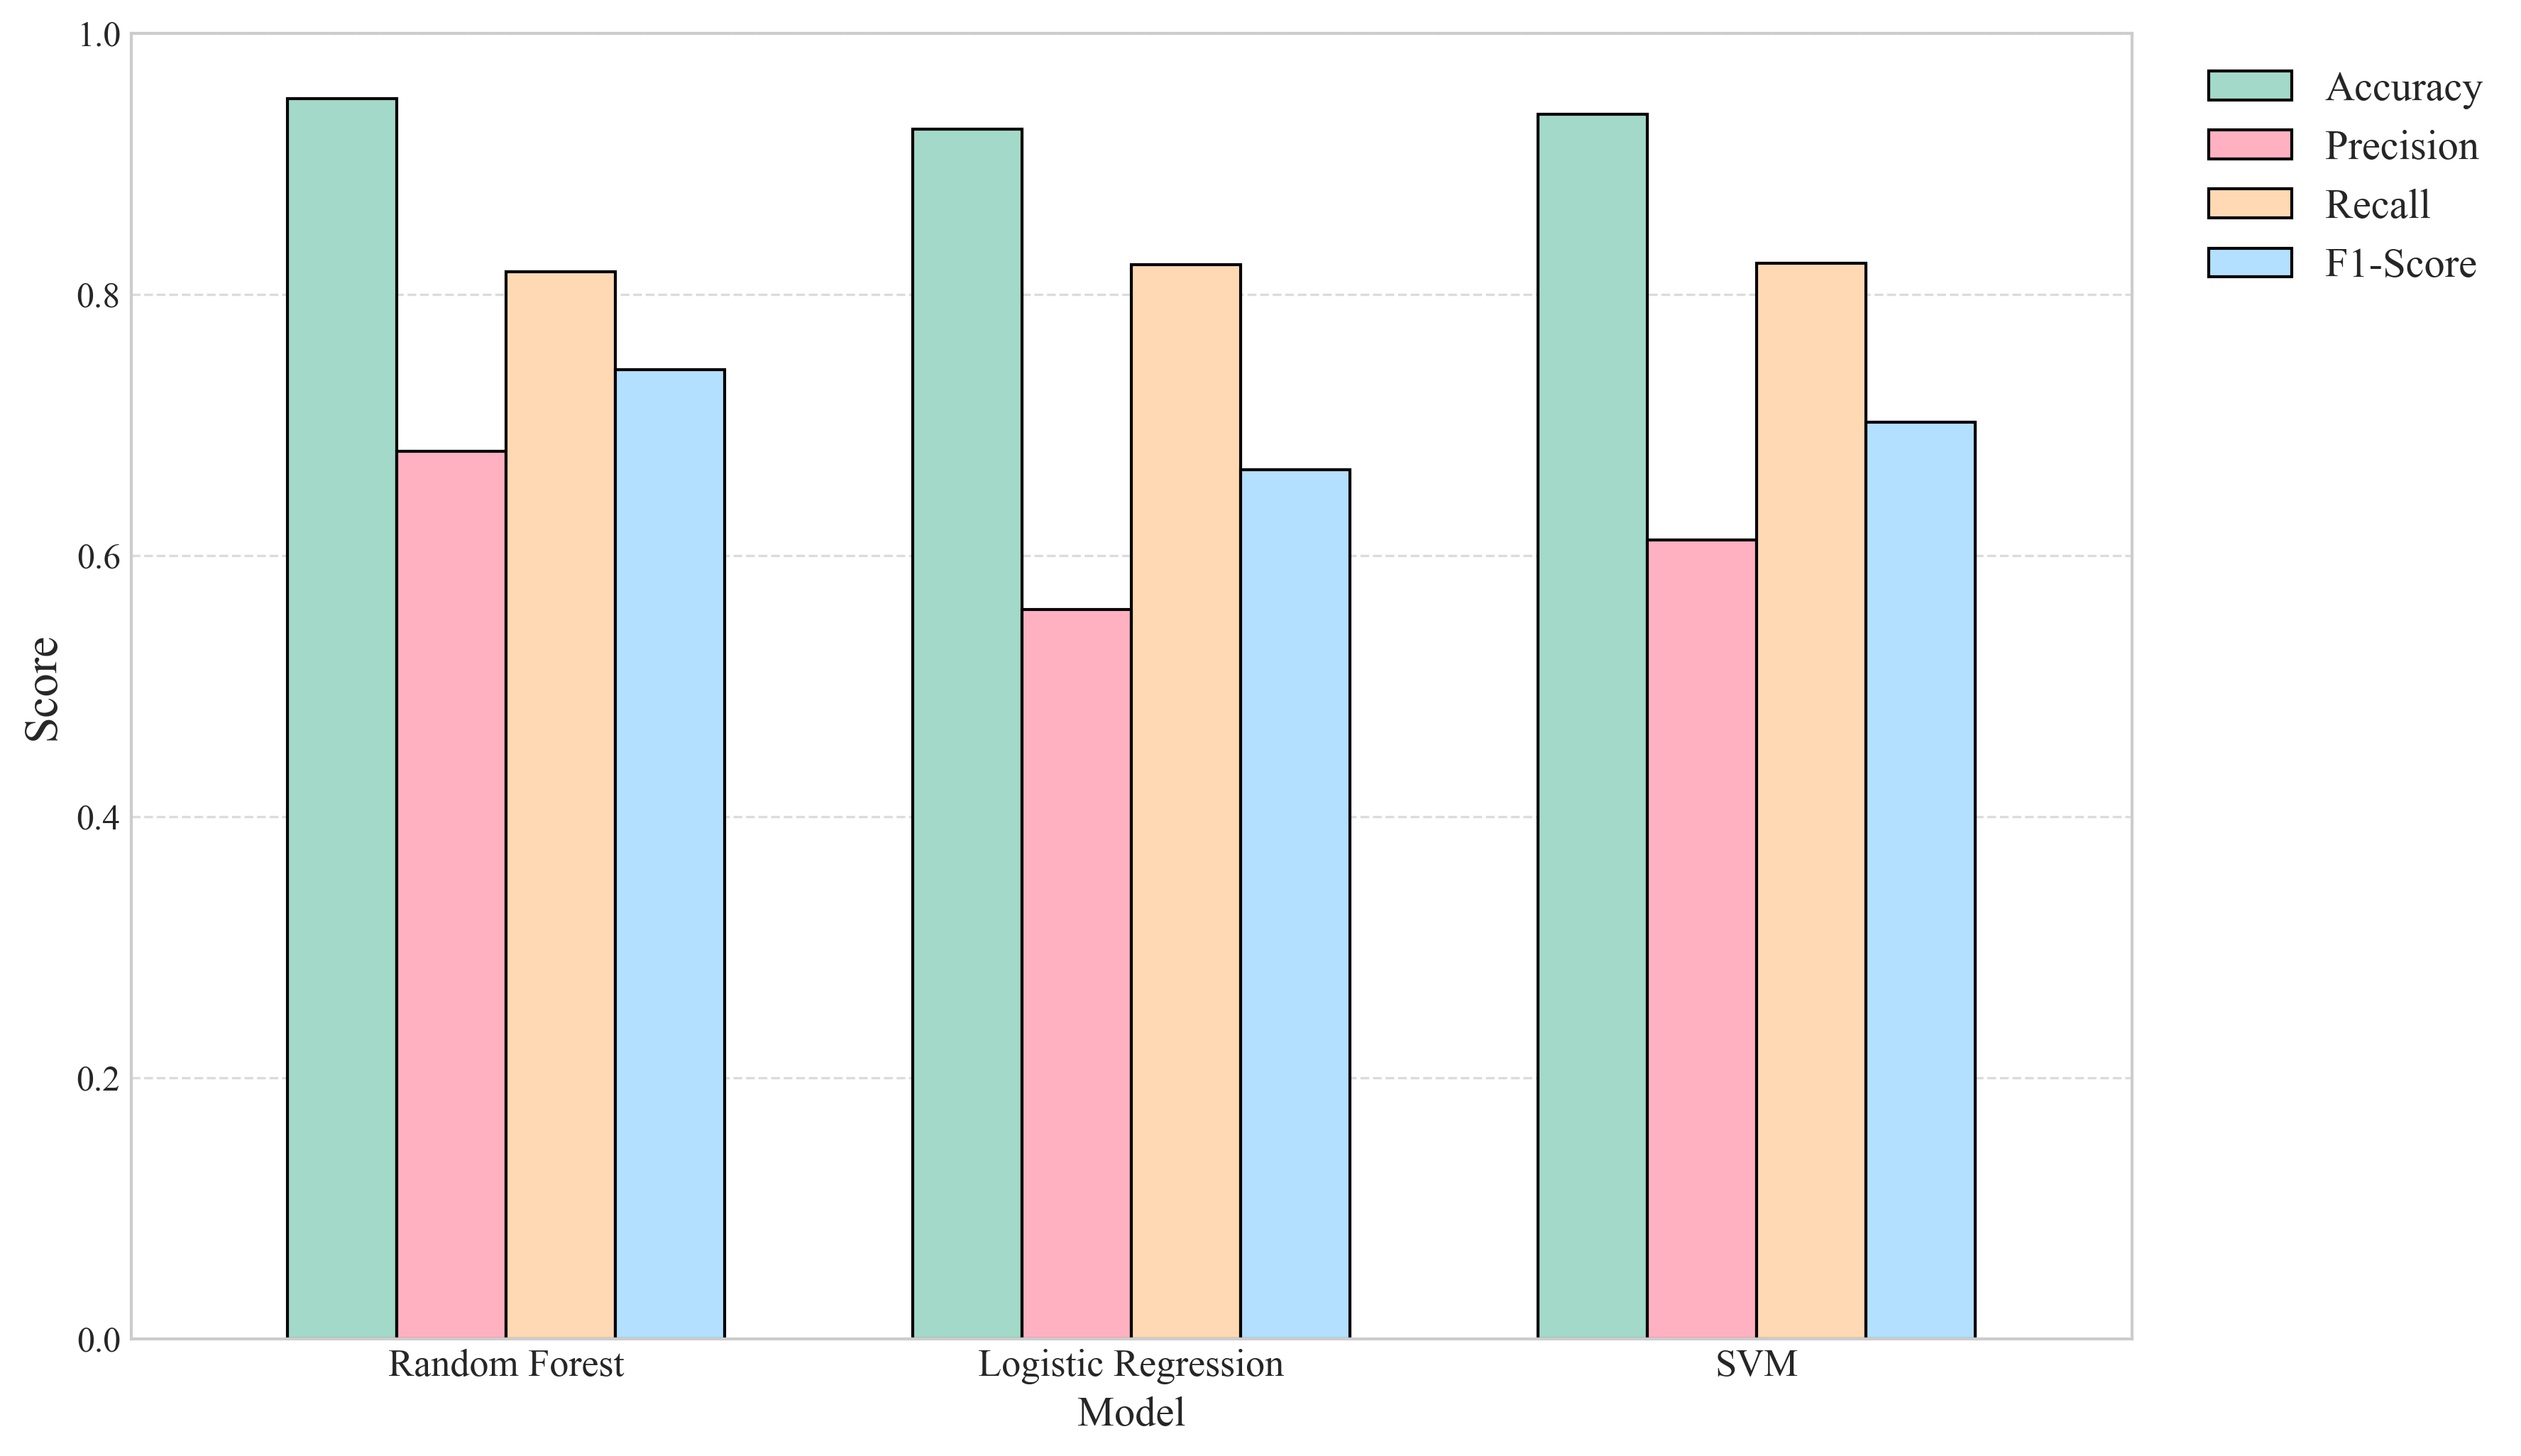

In [33]:
import matplotlib.pyplot as plt

colors = ['#a3d9c9', '#ffb1c1', '#ffd9b3', '#b3e0ff']  # Mint, Pink, Orange, Blue

metrics_df = pd.DataFrame(metrics_list).set_index('Model')
plt.rcParams['font.family'] = 'Times New Roman'

ax = metrics_df.plot(
    kind='bar',
    figsize=(12, 7),
    color=colors,
    edgecolor='black',
    width=0.7
)

plt.ylabel("Score", fontsize=16)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=13)

plt.legend(
    title=None,
    fontsize=14,
    loc='upper left',
    bbox_to_anchor=(1.02, 1)
)

plt.tight_layout()
plt.show()


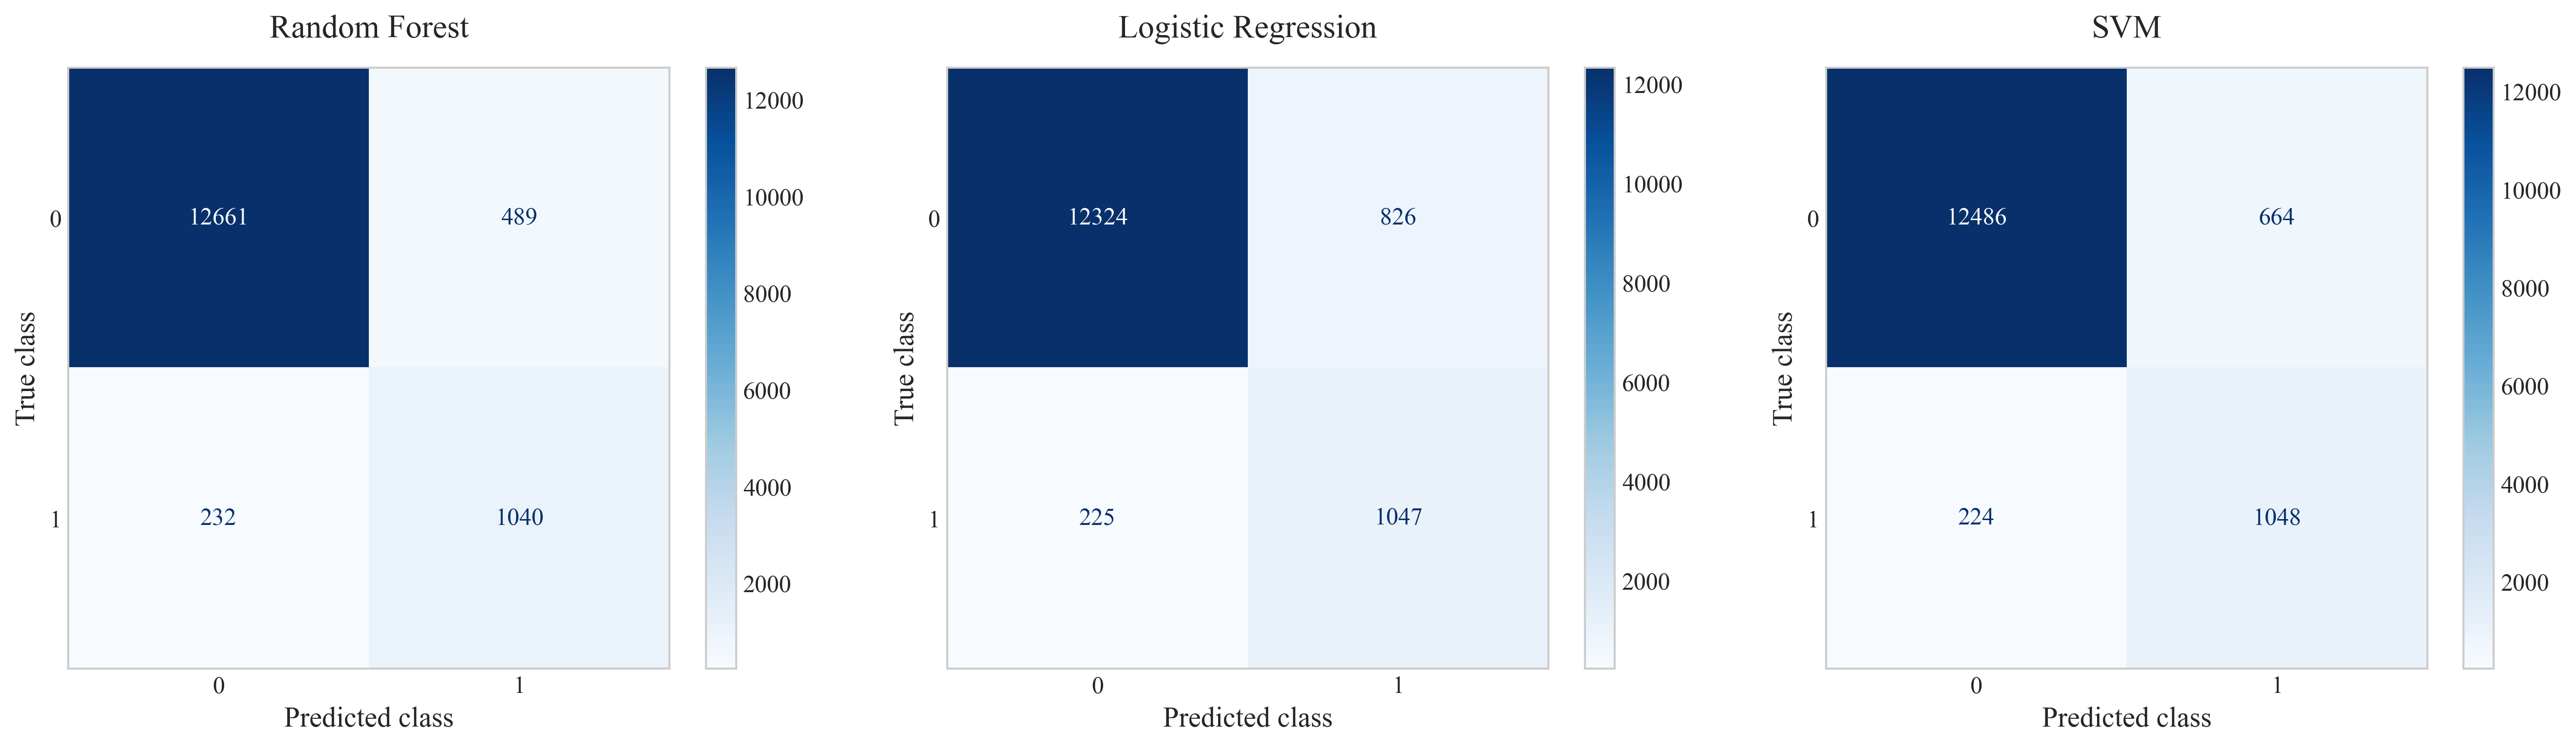

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)
for i, (name, res) in enumerate(results.items()):
    cm = confusion_matrix(y_test, res['y_pred'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[i], cmap='Blues', colorbar=True, values_format='d')
    axes[i].set_title(name, fontsize=16, pad=15)
    axes[i].set_xlabel('Predicted class', fontsize=14)
    axes[i].set_ylabel('True class', fontsize=14)
    axes[i].tick_params(axis='both', labelsize=12)
    axes[i].grid(False)

plt.savefig('figures/confusion_matrices.png', bbox_inches='tight', dpi=300)
plt.show()
